In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno ## 결측치 확인
from fancyimpute import IterativeImputer ## 다중대체
import seaborn.objects as so ## seaborn의 다른 라이브러리
import warnings ## warnings message 표시 안함
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
%config InlineBackend.figure_format = 'retina' ## 선명하게 만들기

### SeoulBikeData_NaN
- Date - 날짜 (년 - 월 - 일)
- Rented Bike Count - 대여된 자전거 수 (각 시간대 별)
- Hour - 시간
- Temperature - 섭씨온도
- Humidity(%) - 상대 습도
- Wind speed - 초당 미터
- Visiblity - 가시성
- Dew point temperature - 이슬점 섭씨온도
- Solar Radiation - 태양 복사량
- Rainfall - 강우량(mm)
- Snowfall - 눈(cm)
- Seasons - 계절(봄, 여름, 가을, 겨울)
- Holiday - 휴일 여부
- Functioning Day - 서비스 이용 가능일 의미

##
- Temperature(°C),  Wind speed (m/s), Seasons 에서 결측치 발생


In [189]:
# read data
data = pd.read_csv("C:\\Users\\서가은\\Desktop\\pre\\SeoulBike\\SeoulBikeData_NaN.csv")
data
data.head()
df = data.copy()
## data는 원본이고, df는 전처리 할 것임 

In [190]:
print(data.info())
print(data.isna().sum())## 결측치, 변수 타입 확인 >> Temperature(°C),  Wind speed (m/s), Seasons 에서 결측치 876개 발생
print('\n',data.describe()) ## 기술 통계량 확인
print('\n',data[data.duplicated()]) ## 중복 행 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 8760 non-null   int64  
 1   Date                       8760 non-null   object 
 2   Rented Bike Count          8760 non-null   int64  
 3   Hour                       8760 non-null   int64  
 4   Temperature(°C)            7884 non-null   float64
 5   Humidity(%)                8760 non-null   int64  
 6   Wind speed (m/s)           7884 non-null   float64
 7   Visibility (10m)           8760 non-null   int64  
 8   Dew point temperature(°C)  8760 non-null   float64
 9   Solar Radiation (MJ/m2)    8760 non-null   float64
 10  Rainfall(mm)               8760 non-null   float64
 11  Snowfall (cm)              8760 non-null   float64
 12  Seasons                    7884 non-null   object 
 13  Holiday                    8760 non-null   objec

### 전처리 전 EDA
#### 상관관계 비교


Text(0.5, 1.0, 'correlation heatmap')

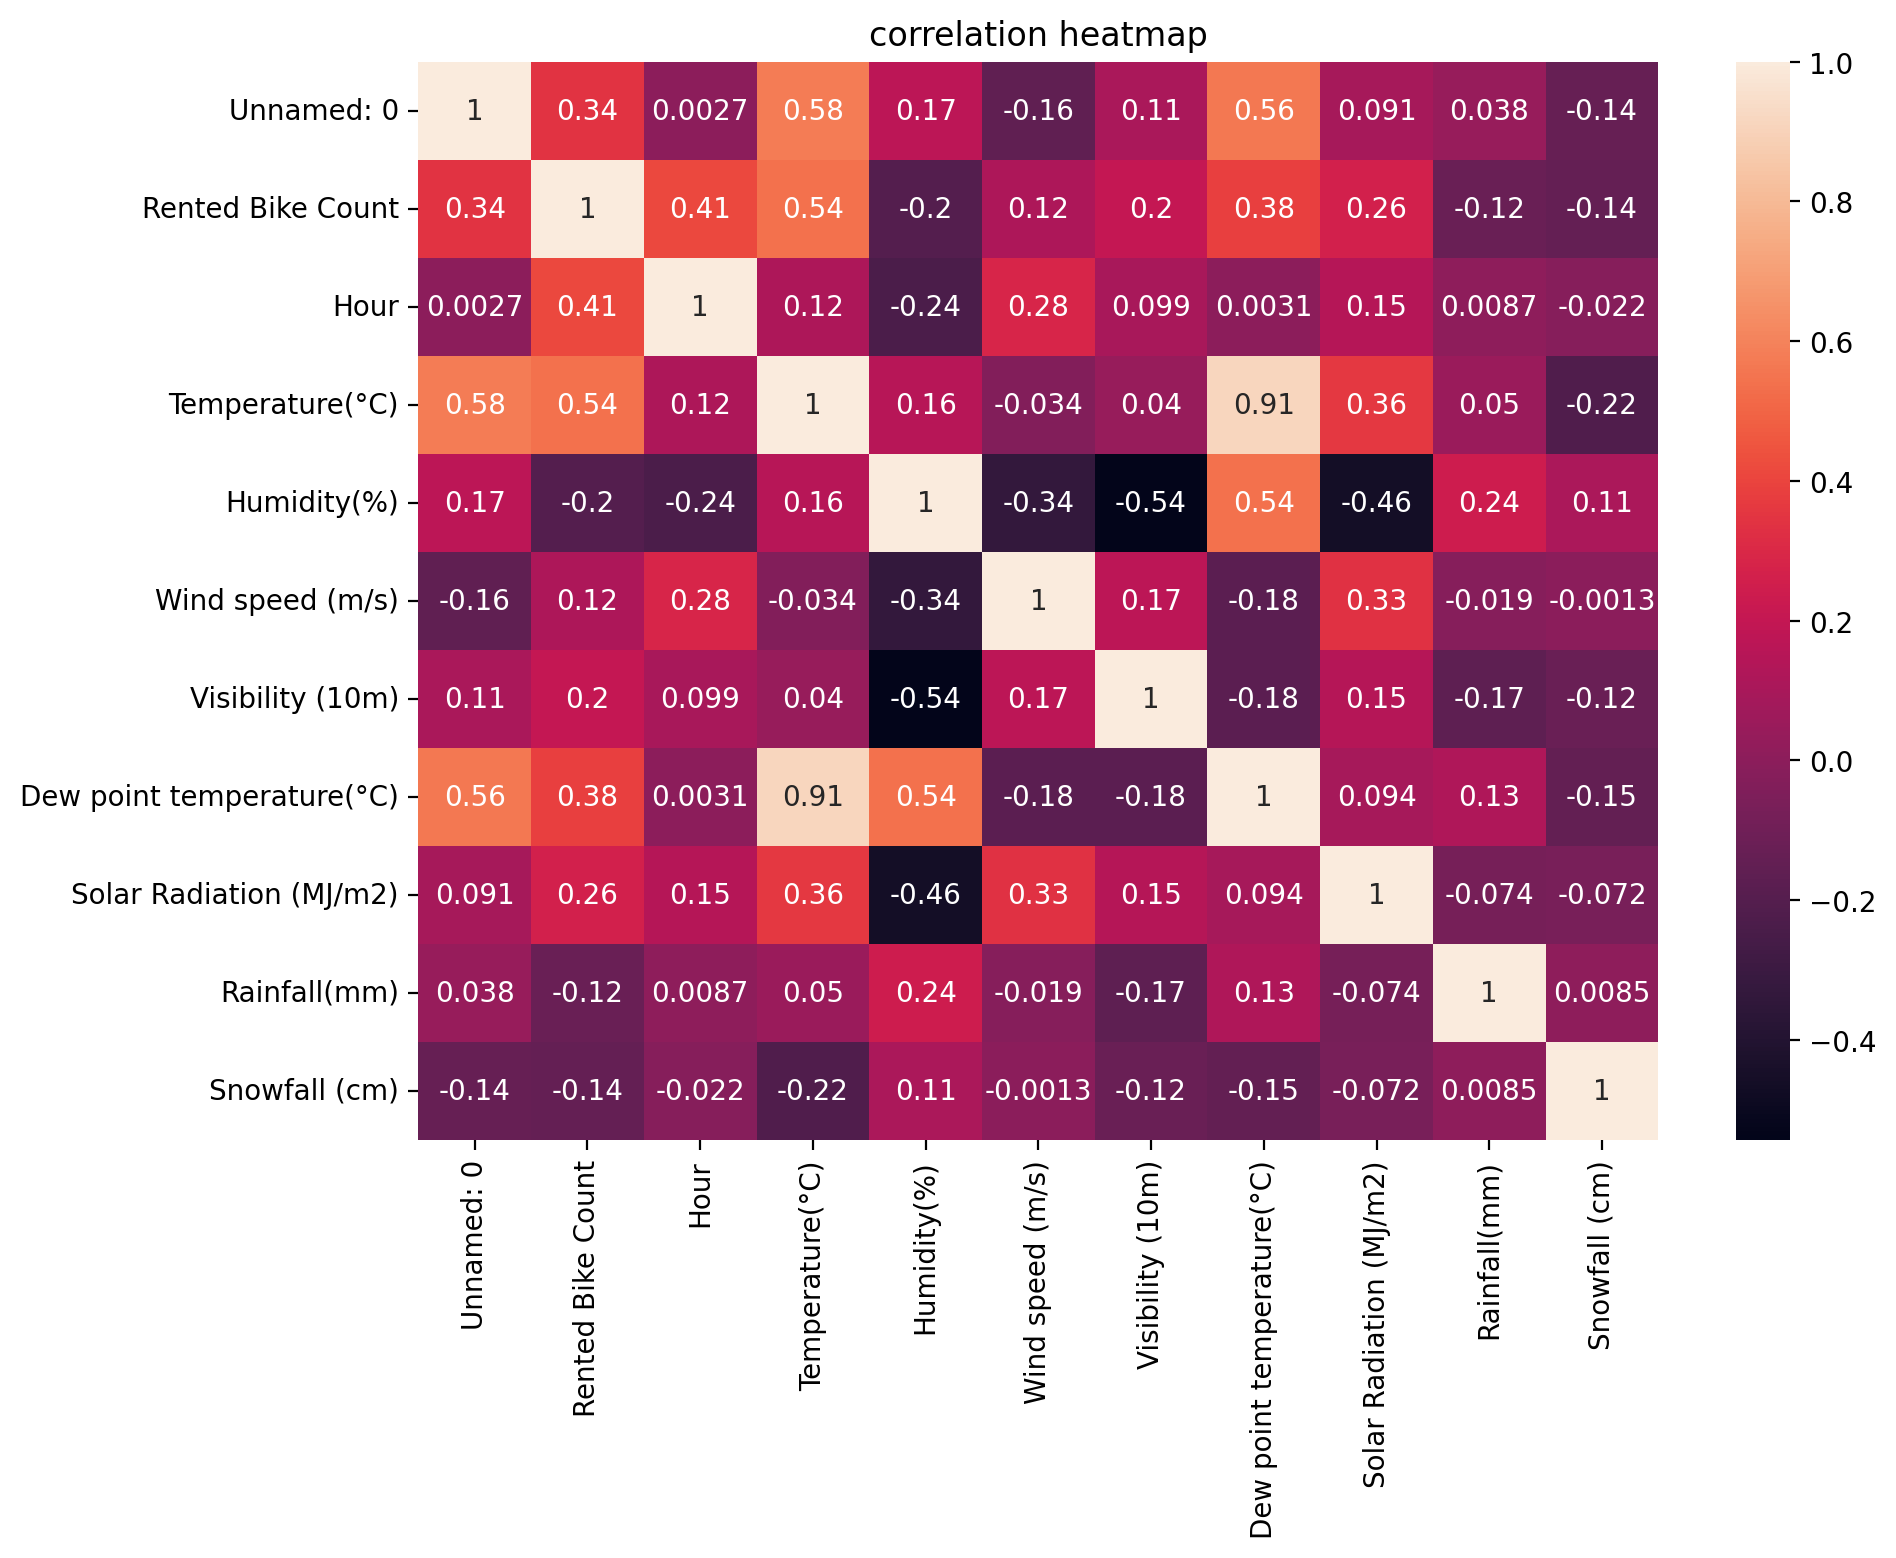

In [191]:
plt.figure(figsize=(10,7))
##sns.heatmap(data.corr(),annot=True) 이렇게 하면 문자형 변수 때문에 오류남
sns.heatmap(data._get_numeric_data().corr() , annot=True) ## dataframenamd._get_numeric_data()
plt.title('correlation heatmap')

Text(0.5, 1.0, 'correlation heatmap (corr > 0.45)')

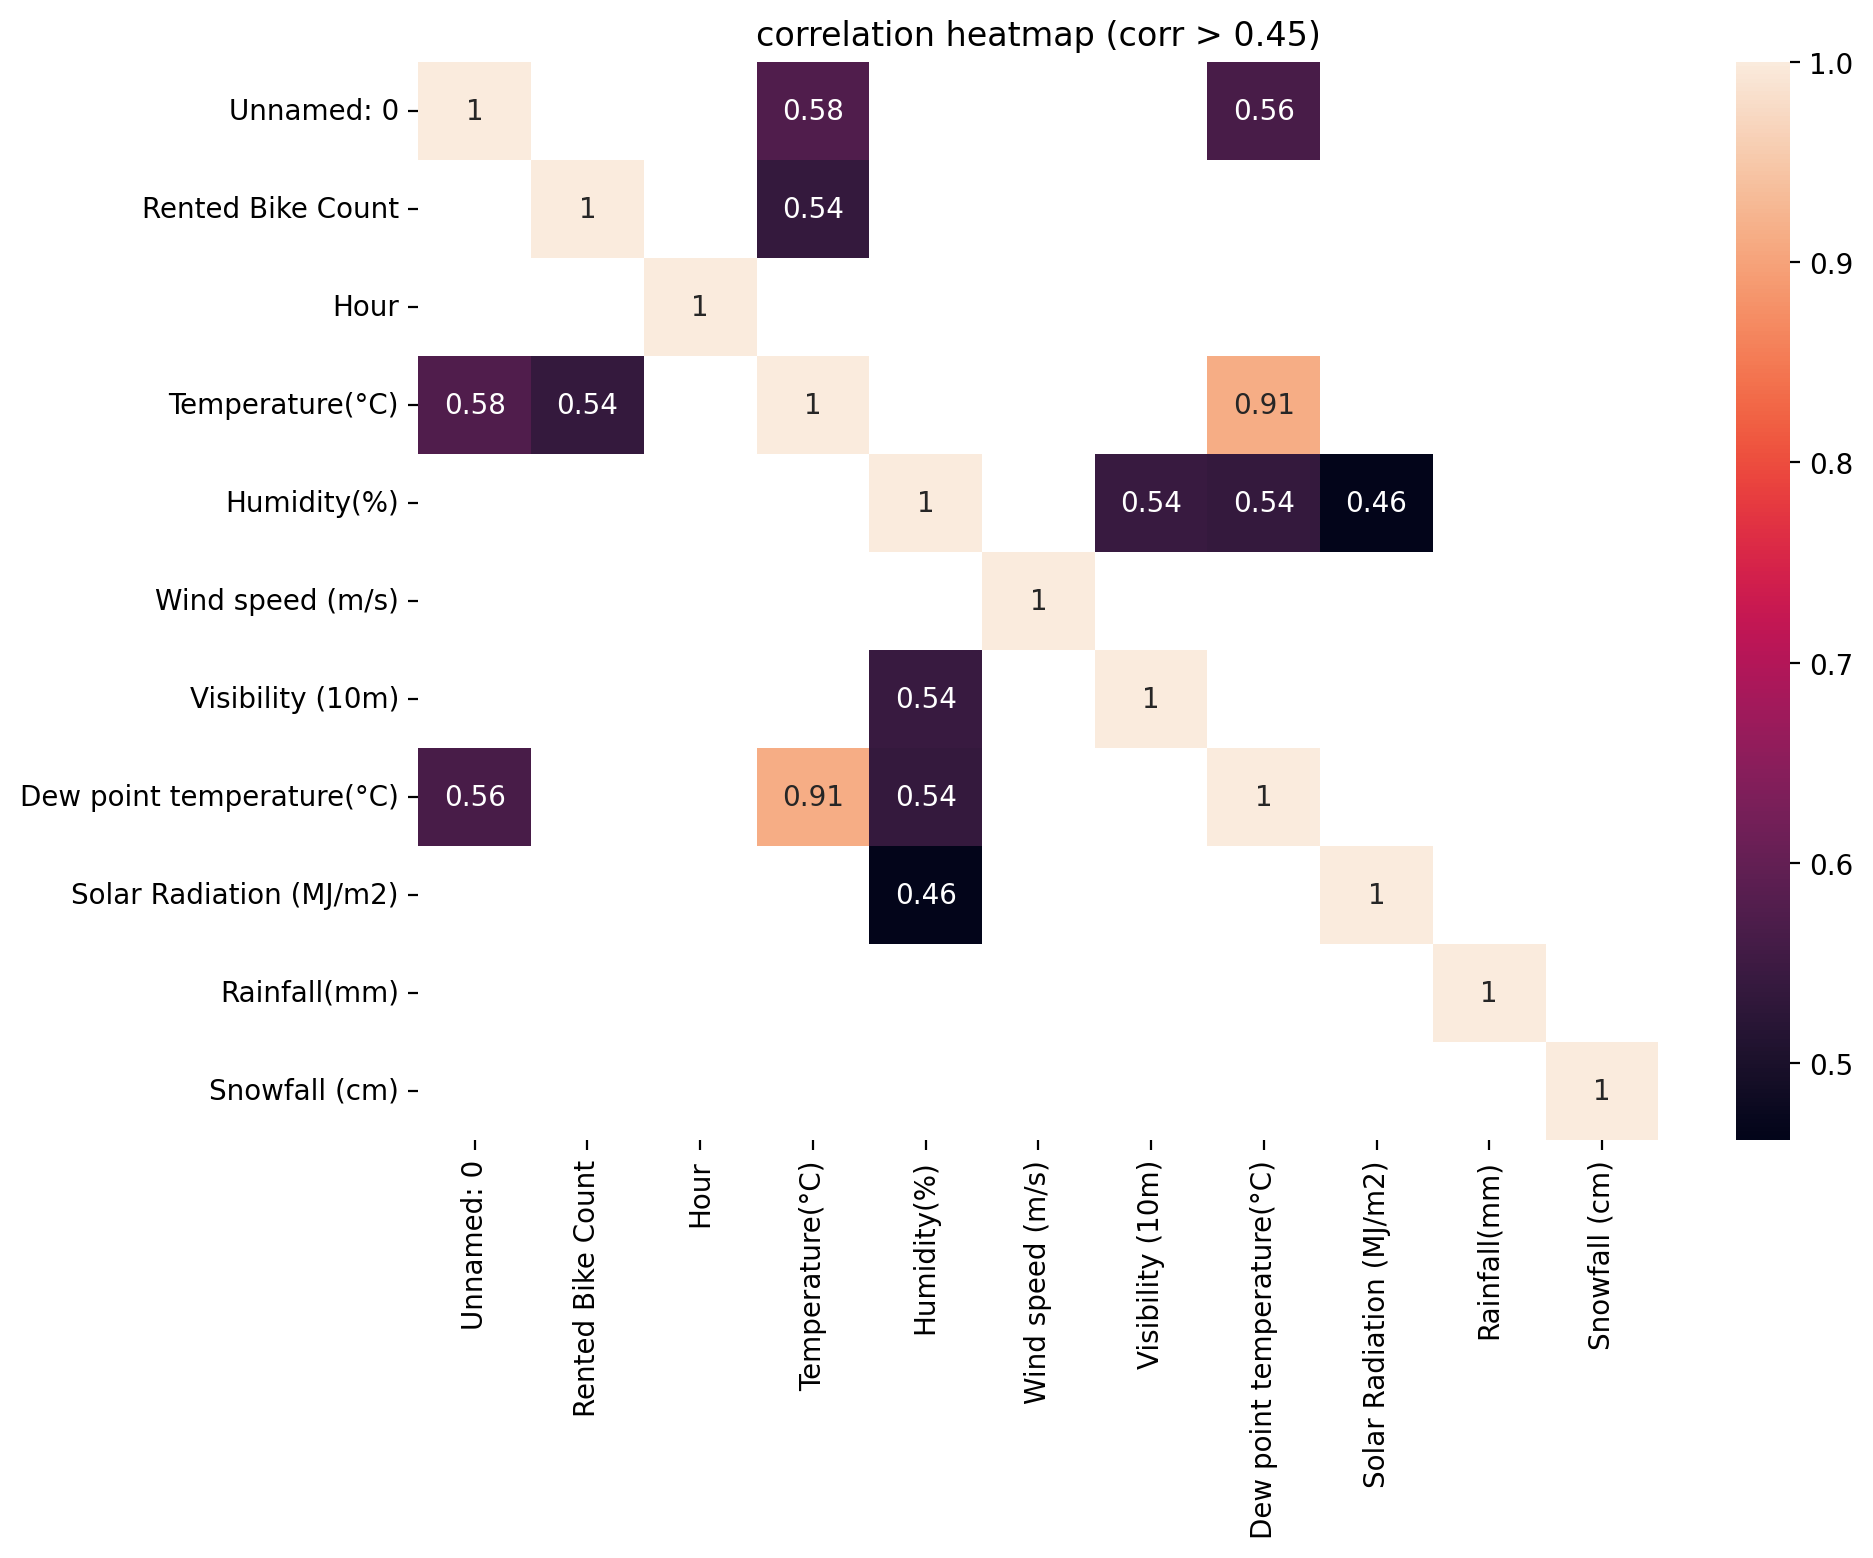

In [192]:
## 높은 상관계수로만 heatmap보기
# sns.heatmap(data._get_numeric_data().corr().abs() > 0.45 , annot=True)
corr_mat = data._get_numeric_data().corr().abs()
filtered_corr = corr_mat.where(corr_mat > 0.45)
plt.figure(figsize=(10,7))
sns.heatmap(filtered_corr, annot= True)
plt.title('correlation heatmap (corr > 0.45)')

In [193]:
print(data['Seasons'].value_counts())
print('\n',data['Holiday'].value_counts())
print('\n',data['Functioning Day'].value_counts())
print('\n',data.groupby('Seasons')['Rented Bike Count'].sum()) ## 계절별 대여량
print('\n',data.groupby('Holiday')['Rented Bike Count'].sum()) ## 휴일 여부 별 대여량
print('\n',data.groupby('Functioning Day')['Rented Bike Count'].sum()) ## 운영일 별 대여량

Seasons
Spring    1990
Summer    1990
Autumn    1969
Winter    1935
Name: count, dtype: int64

 Holiday
No Holiday    8328
Holiday        432
Name: count, dtype: int64

 Functioning Day
Yes    8465
No      295
Name: count, dtype: int64

 Seasons
Autumn    1607599
Spring    1436864
Summer    2063336
Winter     437834
Name: Rented Bike Count, dtype: int64

 Holiday
Holiday        215895
No Holiday    5956419
Name: Rented Bike Count, dtype: int64

 Functioning Day
No           0
Yes    6172314
Name: Rented Bike Count, dtype: int64


In [194]:
## 원본 데이터와의 구별을 위해 결측치 처리 및 후 전처리는 df로 진행
df.isna().sum()

Unnamed: 0                     0
Date                           0
Rented Bike Count              0
Hour                           0
Temperature(°C)              876
Humidity(%)                    0
Wind speed (m/s)             876
Visibility (10m)               0
Dew point temperature(°C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                   0
Snowfall (cm)                  0
Seasons                      876
Holiday                        0
Functioning Day                0
dtype: int64

## 2. 결측치 처리

## 2-1. 결측치 처리 - 제거
- inplace=True : 새로운 객체를 생성하지 않고 원래 객체 변경

In [195]:
df1 = df.copy()
df1.dropna(subset=['Temperature(°C)', 'Wind speed (m/s)', 'Seasons'], inplace=True)
df1.isna().sum() ## 결측치 제거됨을 확인

Unnamed: 0                   0
Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

Text(0.5, 1.0, 'correlation heatmap (corr > 0.45)')

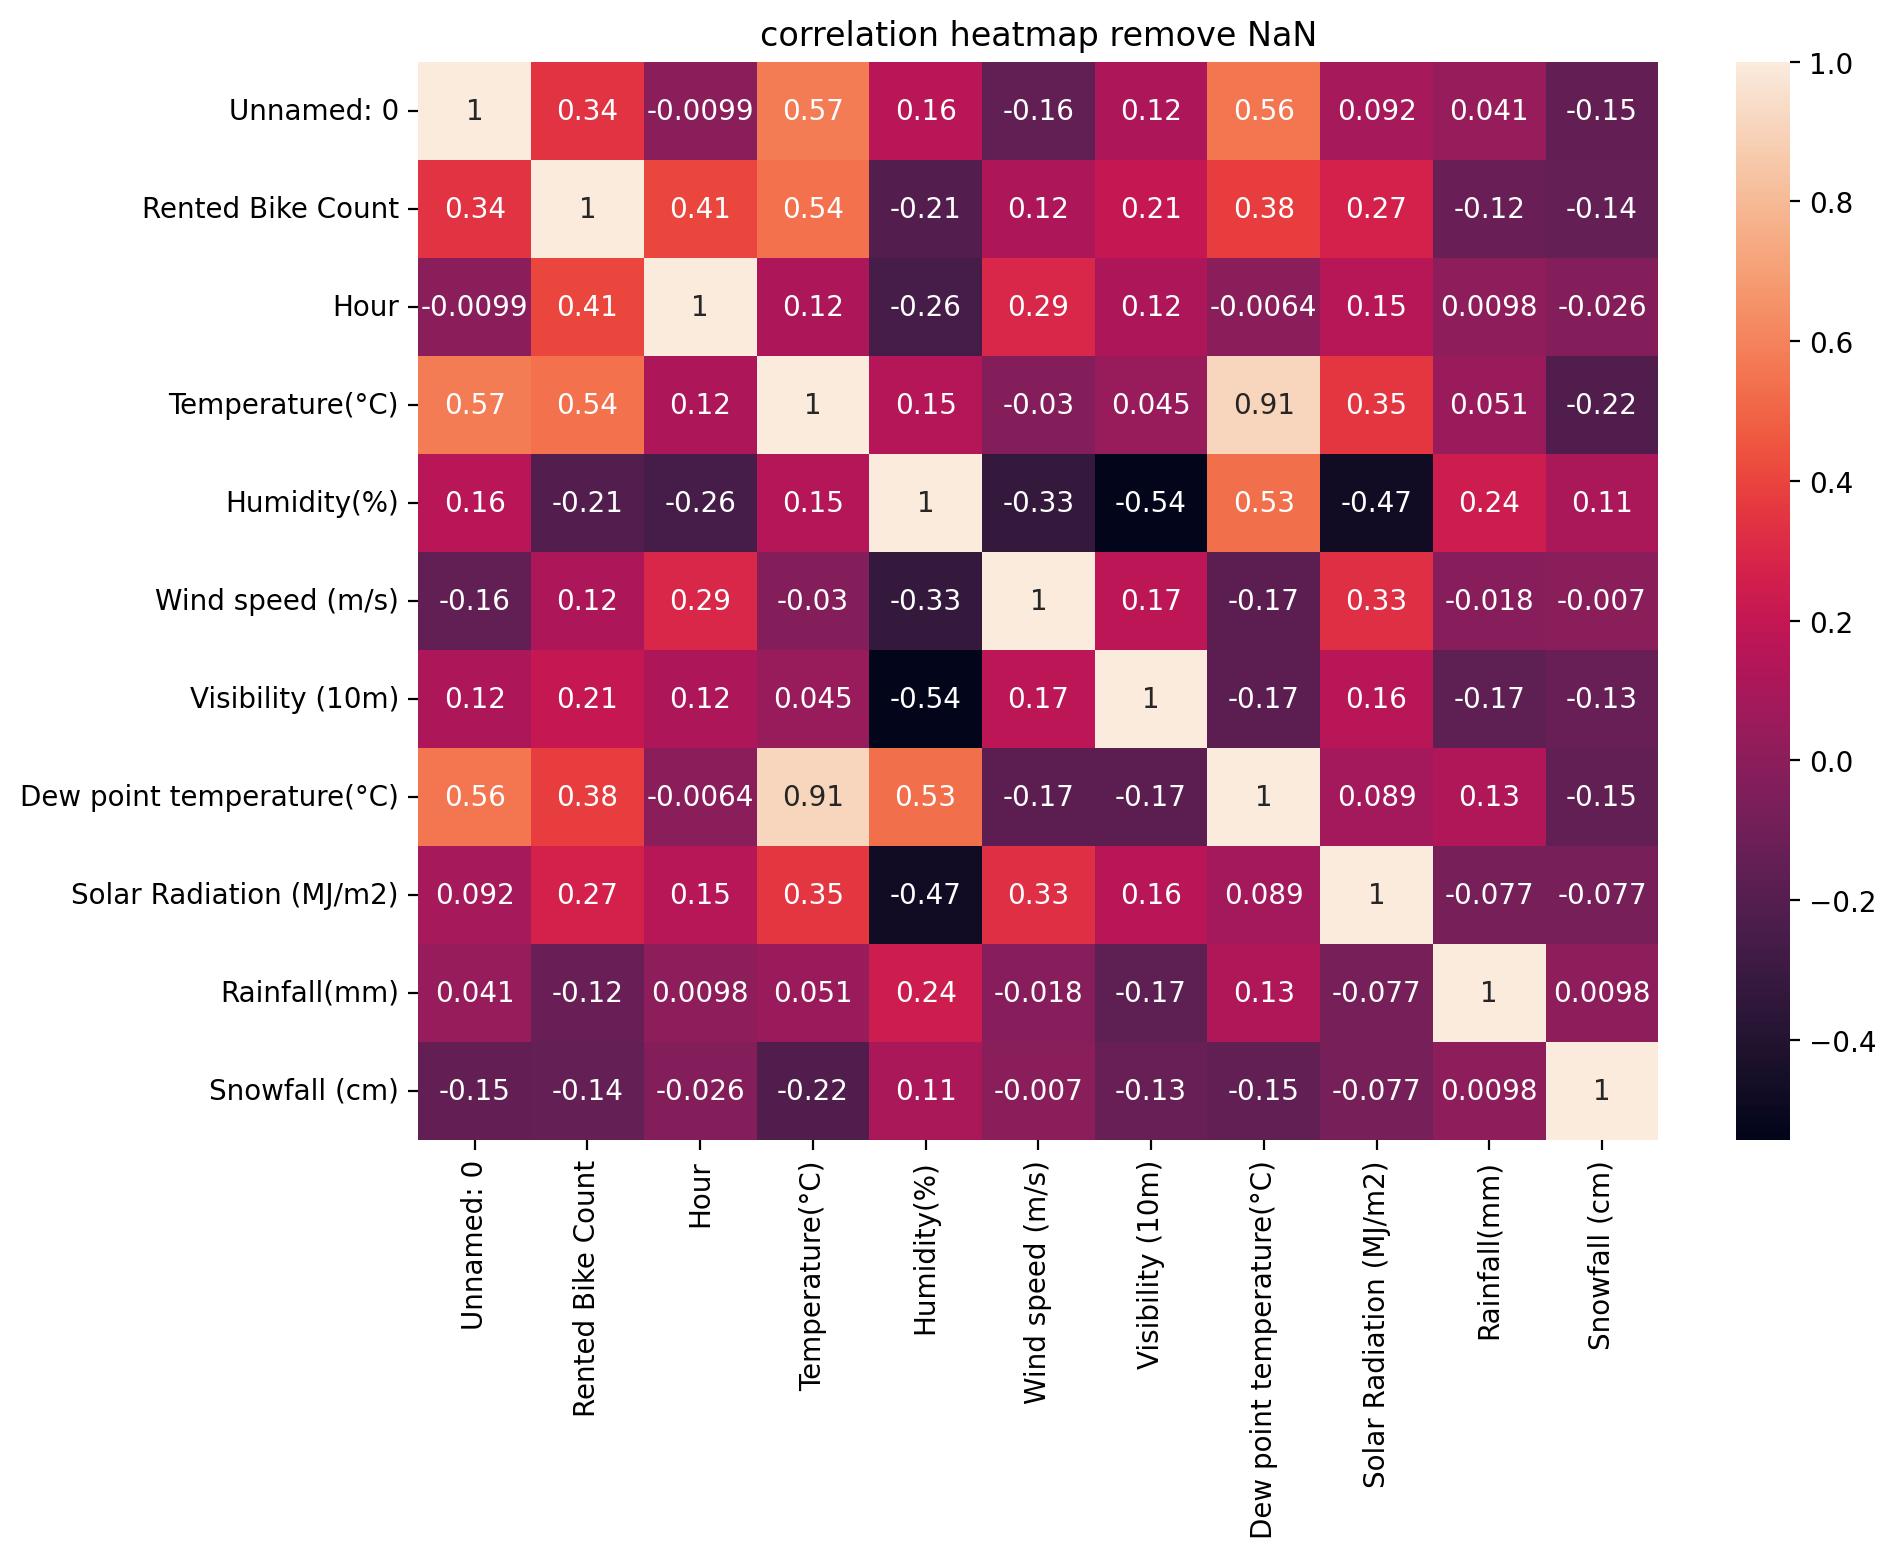

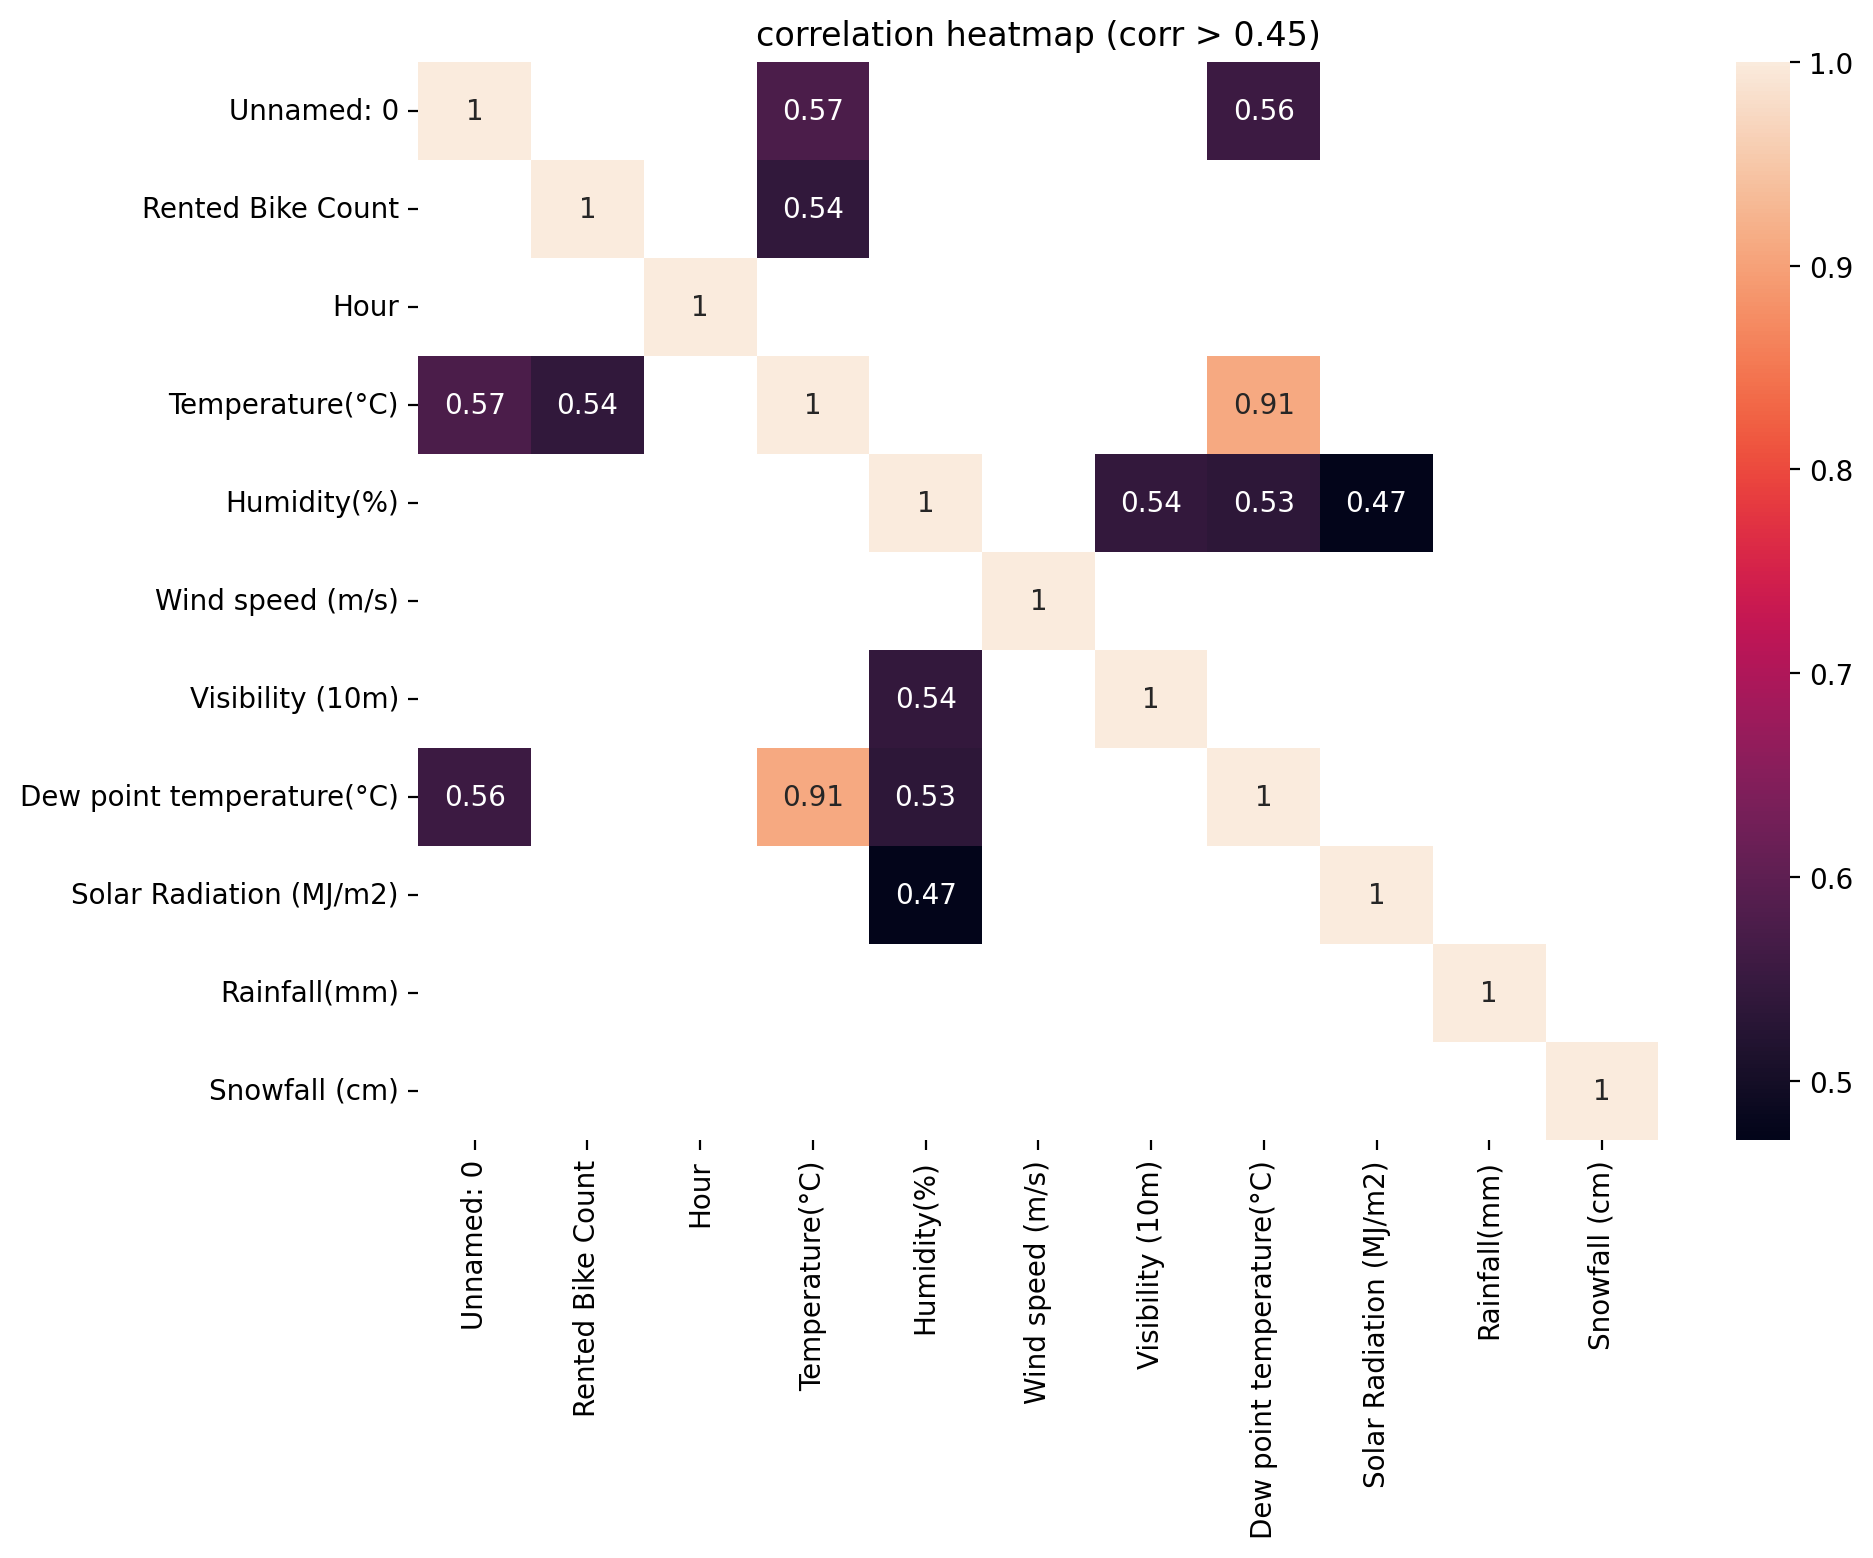

In [196]:
plt.figure(figsize=(10,7))
sns.heatmap(df1._get_numeric_data().corr() , annot=True) ## dataframenamd._get_numeric_data()
plt.title('correlation heatmap remove NaN')
## 결측치 처리 전보다 상관계수 변화 살짝 있음

corr_mat = df1._get_numeric_data().corr().abs()
filtered_corr = corr_mat.where(corr_mat > 0.45)
plt.figure(figsize=(10,7))
sns.heatmap(filtered_corr, annot= True)
plt.title('correlation heatmap (corr > 0.45)')

## 2-2. 결측치 처리 - 대체 (단일 대체)
- 일단은 평균으로 대체할것임, 평균과 중앙값 차이가 별로 없음(온도, 풍속)
- 소수점 첫째자리까지 사용

In [197]:
df2 = df.copy()
df2.isna().sum()

Unnamed: 0                     0
Date                           0
Rented Bike Count              0
Hour                           0
Temperature(°C)              876
Humidity(%)                    0
Wind speed (m/s)             876
Visibility (10m)               0
Dew point temperature(°C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                   0
Snowfall (cm)                  0
Seasons                      876
Holiday                        0
Functioning Day                0
dtype: int64

In [198]:
## 온도에 대한 통계량 확인
print(f'평균 : {(df["Temperature(°C)"].mean())}') ## 평균온도 13도
print(f'중앙값 : {(df["Temperature(°C)"].median())}') ## 온도 중앙값 14도
print(f'최빈값 : {(df["Temperature(°C)"].mode()[0])}') ## 온도 최빈값 20.5도

평균 : 13.026369863013697
중앙값 : 13.95
최빈값 : 20.5


In [199]:
## 풍속에 대한 통계량확인
print(f'평균 : {(df["Wind speed (m/s)"].mean())}') ## 평균풍속 1.7m/s
print(f'중앙값 : {(df["Wind speed (m/s)"].median())}') ## 풍속 중앙값 1.5m/s
print(f'최빈값 : {(df["Wind speed (m/s)"].mode()[0])}') ## 풍속 최빈값 1.1m/s


평균 : 1.7272196854388635
중앙값 : 1.5
최빈값 : 1.1


In [200]:
## 계절에 대한 통계량 확인
print(df['Seasons'].value_counts()) ## 계절별 데이터 개수 확임
## 계절 최빈값 Spring = Summer


Seasons
Spring    1990
Summer    1990
Autumn    1969
Winter    1935
Name: count, dtype: int64


In [201]:
df2["Temperature(°C)"] = df["Temperature(°C)"].fillna((df["Temperature(°C)"].mean())) ## 평균으로 대체
df2["Wind speed (m/s)"] = df["Wind speed (m/s)"].fillna((df["Wind speed (m/s)"].mean())) ## 평균으로 대체
# df2["Seasons"] = df["Seasons"].fillna((df["Seasons"]==)) ## 평균으로 대체
print(f'대체 전 : {df["Temperature(°C)"].isna().sum()}')
print(f'대체 후 : {df2["Temperature(°C)"].isna().sum()}')  
print(f'대체 전 : {df["Wind speed (m/s)"].isna().sum()}')
print(f'대체 후 : {df2["Wind speed (m/s)"].isna().sum()}')  
print(f'대체 전 : {df["Seasons"].isna().sum()}')
print(f'대체 후 : {df2["Seasons"].isna().sum()}')  

대체 전 : 876
대체 후 : 0
대체 전 : 876
대체 후 : 0
대체 전 : 876
대체 후 : 876


In [202]:
df2.isna().sum()

Unnamed: 0                     0
Date                           0
Rented Bike Count              0
Hour                           0
Temperature(°C)                0
Humidity(%)                    0
Wind speed (m/s)               0
Visibility (10m)               0
Dew point temperature(°C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                   0
Snowfall (cm)                  0
Seasons                      876
Holiday                        0
Functioning Day                0
dtype: int64

## 2-3. 결측치 처리 - 이전행의 값으로 대체
- 날씨(온도, 풍속, 계절)이다보니 인접한 행과 비슷할 수 밖에 없을 것이라고 생각이 들었음
- 예상 밖으로 온도에 대한 결측치를 평균값으로 채우는 것과, 인접한 행의 값으로 채우는 것에서 상관관계 차이는 매우 적음

In [204]:
df3 = df.copy()
df3.isna().sum()

Unnamed: 0                     0
Date                           0
Rented Bike Count              0
Hour                           0
Temperature(°C)              876
Humidity(%)                    0
Wind speed (m/s)             876
Visibility (10m)               0
Dew point temperature(°C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                   0
Snowfall (cm)                  0
Seasons                      876
Holiday                        0
Functioning Day                0
dtype: int64

In [205]:
## 온도의 결측치를 이전 온도로 대체
df3['Temperature(°C)'] = df['Temperature(°C)'].fillna(method='ffill')  # 이전 값으로 대체, bfill이면 다음값으로 대체
print(f'대체 전 : {df["Temperature(°C)"].isna().sum()}')
print(f'대체 후 : {df3["Temperature(°C)"].isna().sum()}') 

print(df3['Temperature(°C)'].mean()) ## 앞에서 구한 평균온도와 0.2도정도 차이남을 확인할 수 있음


대체 전 : 876
대체 후 : 0
12.888333333333332


In [206]:
## 풍속의 결측치를 이전행의 풍속으로 대체
df3['Wind speed (m/s)'] = df['Wind speed (m/s)'].fillna(method='ffill')  # 이전 값으로 대체
print(f'대체 전 : {df["Wind speed (m/s)"].isna().sum()}')
print(f'대체 후 : {df3["Wind speed (m/s)"].isna().sum()}') 
 
print(df3['Wind speed (m/s)'].mean()) ## 앞에서 구한 평균풍속과 거의 차이 없음
print(df3.groupby('Seasons')['Wind speed (m/s)'].mean()) ## 계절별 평균풍속은 다음과 같음

대체 전 : 876
대체 후 : 0
1.7207876712328767
Seasons
Autumn    1.488979
Spring    1.863467
Summer    1.626432
Winter    1.905685
Name: Wind speed (m/s), dtype: float64


In [207]:
## 계절의 결측치를 이전행의 계절로 대체
df3['Seasons'] = df['Seasons'].fillna(method='ffill')  # 이전 값으로 대체
print(f'대체 전 : {df["Seasons"].isna().sum()}')
print(f'대체 후 : {df3["Seasons"].isna().sum()}') 
print(df3['Seasons'].value_counts()) ## 계절별 데이터 개수 확인
df3['Seasons'].isna().sum()
df3['Seasons'] ## 맨 위의 행이 결측값이라는 사실을 바로 알 수 있음
df3['Seasons'] = df3['Seasons'].fillna('Winter') ## 결측치 Winter로 변경
print(f'결측치 확인 : {df3["Seasons"].isna().sum()}') ## 결측치 없음
print(df3['Seasons'].value_counts()) ## 계절별 데이터 개수 다시 확인 

대체 전 : 876
대체 후 : 1
Seasons
Spring    2208
Summer    2208
Autumn    2184
Winter    2159
Name: count, dtype: int64
결측치 확인 : 0
Seasons
Spring    2208
Summer    2208
Autumn    2184
Winter    2160
Name: count, dtype: int64


Text(0.5, 1.0, 'correlation heatmap (corr > 0.45)')

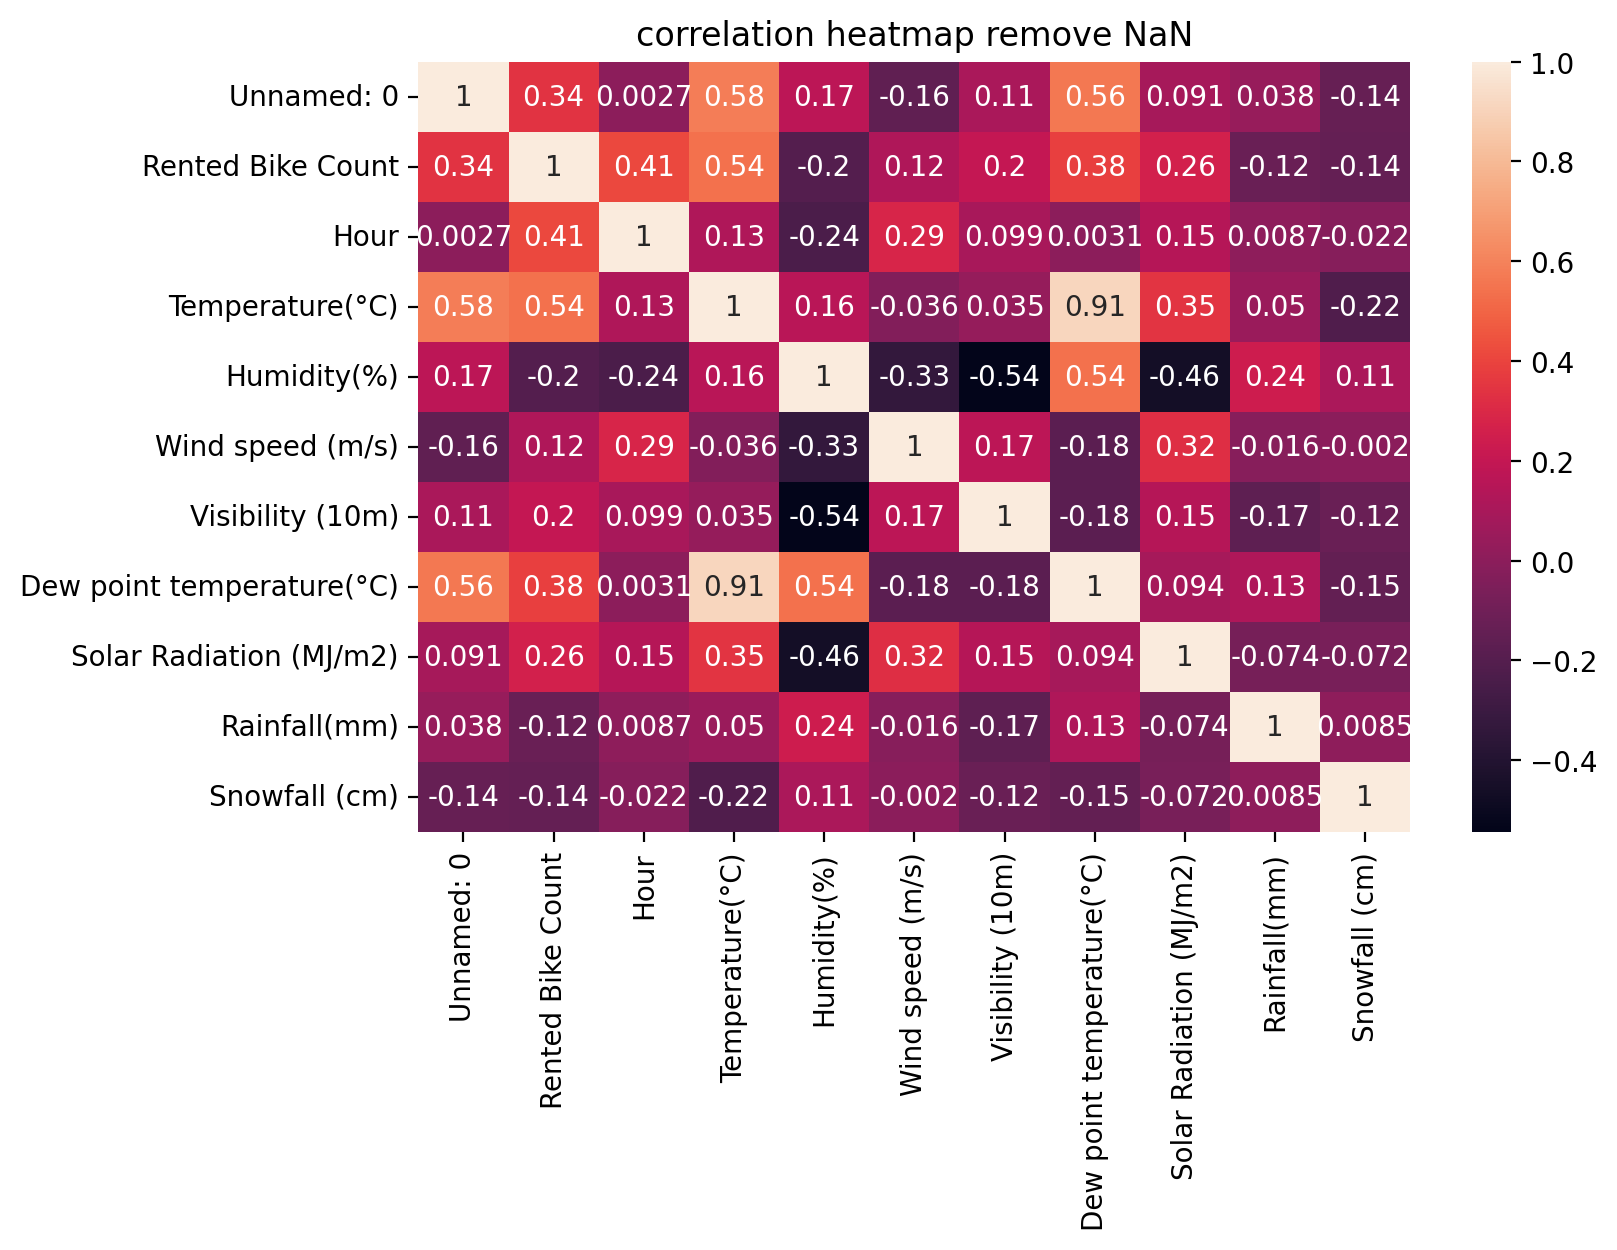

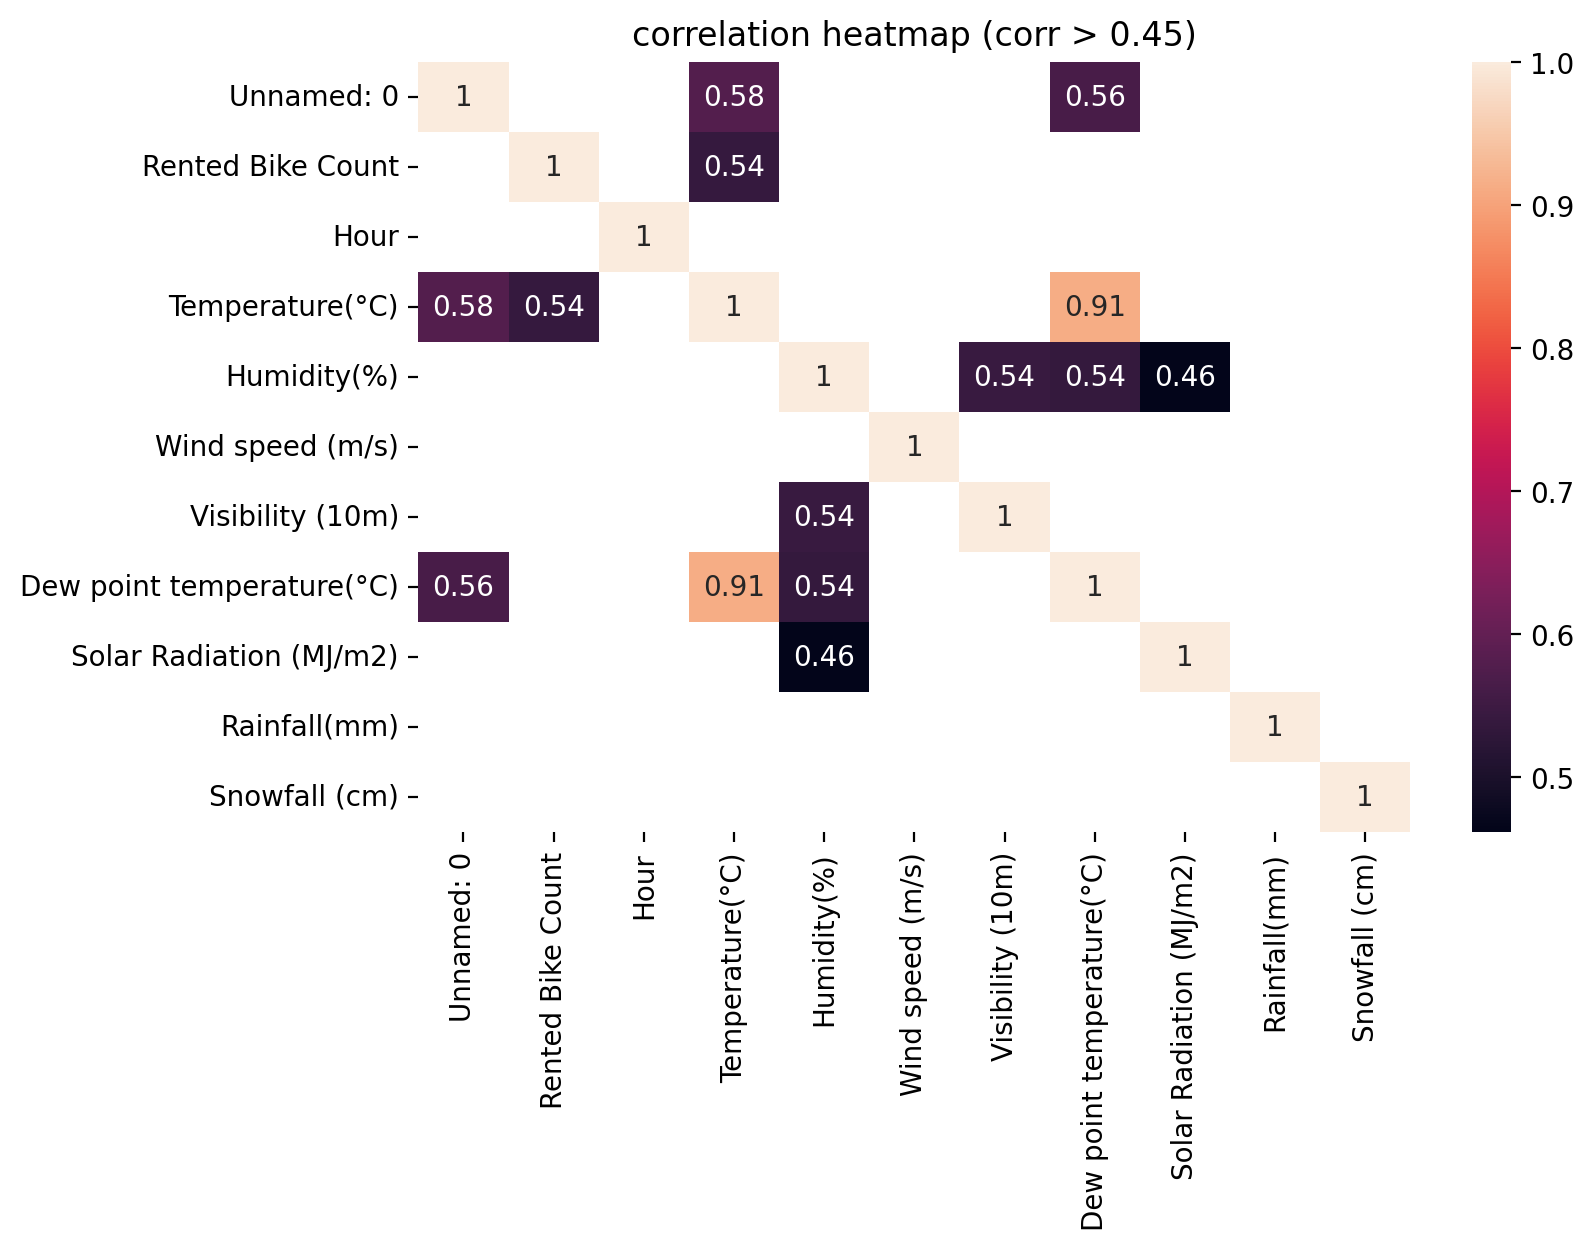

In [208]:
plt.figure(figsize=(8,5))
sns.heatmap(df3._get_numeric_data().corr() , annot=True) ## dataframenamd._get_numeric_data()
plt.title('correlation heatmap remove NaN')
## 결측치 처리 전보다 상관계수 변화 살짝 있음(결측치 제거한 결과와 큰 차이가 나타나지 않음)

corr_mat = df3._get_numeric_data().corr().abs()
filtered_corr = corr_mat.where(corr_mat > 0.45)
plt.figure(figsize=(8,5))
sns.heatmap(filtered_corr, annot= True)
plt.title('correlation heatmap (corr > 0.45)')

### 2-3-1. 이상치 확인
- 기상청에 근거하면 서울의 연평균 풍속은 2.3m/s 이며
 9월에 1.9정도로 가장 낮고, 4월에 2.7m정도로 가장 높다고 한다.
 따라서 풍속데이터에는 이상치가 있는것으로 판단.

count    8760.000000
mean       12.888333
std        11.948531
min       -17.800000
25%         3.400000
50%        13.800000
75%        22.500000
max        39.400000
Name: Temperature(°C), dtype: float64
Unnamed: 0  Date        Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm)  Seasons  Holiday     Functioning Day
5849        01/08/2018  1033               17    39.0             41           2.6               1881              23.3                       1.83                     0.0           0.0            Summer   No Holiday  Yes                1
Name: count, dtype: int64


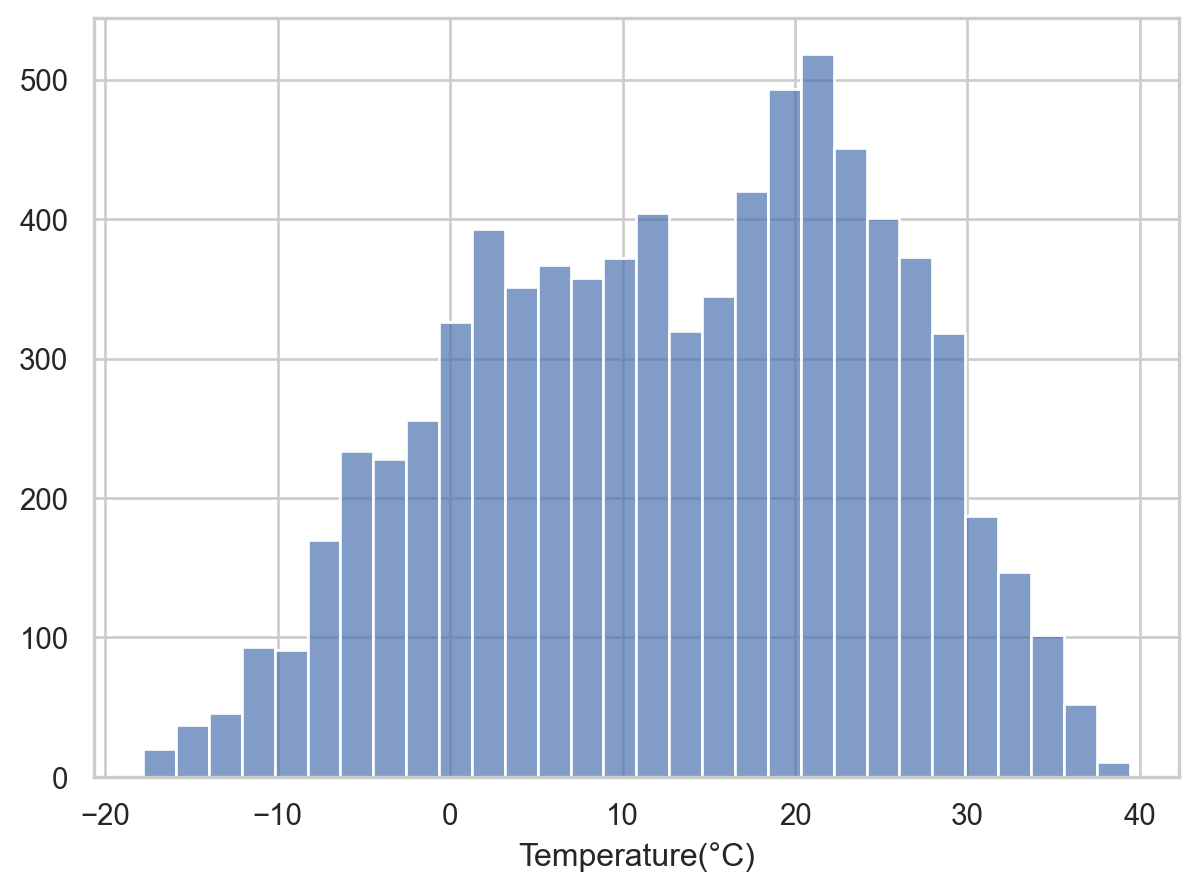

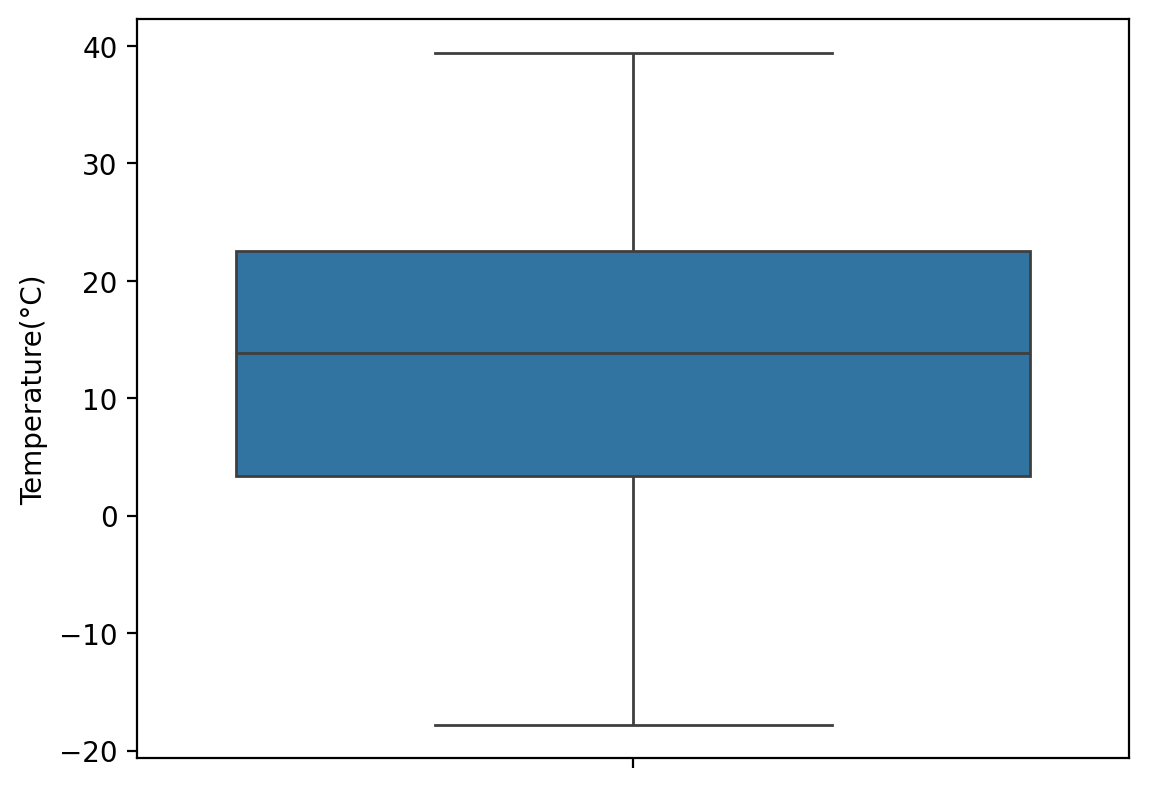

In [209]:
## 온도에 대한 이상치 확인
print(df3['Temperature(°C)'].describe())
print(df3[df3['Temperature(°C)']==39].value_counts()) ## 온도가 39도인 행을 확인
sns.boxplot(df3['Temperature(°C)']) ## 온도에는 이상치 없음 
so.Plot(df, x='Temperature(°C)').add(so.Bars(), so.Hist()).theme({**sns.axes_style("whitegrid")})

count    8760.000000
mean        1.720788
std         1.033319
min         0.000000
25%         0.900000
50%         1.500000
75%         2.300000
max         7.400000
Name: Wind speed (m/s), dtype: float64
Unnamed: 0  Date        Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm)  Seasons  Holiday     Functioning Day
3134        10/04/2018  913                14    21.2             35           7.4               1992              5.1                        1.80                     0.0           0.0            Spring   No Holiday  Yes                1
3135        10/04/2018  933                15    21.4             33           7.4               1998              4.4                        1.63                     0.0           0.0            Spring   No Holiday  Yes                1
Name: count, dtype: int64


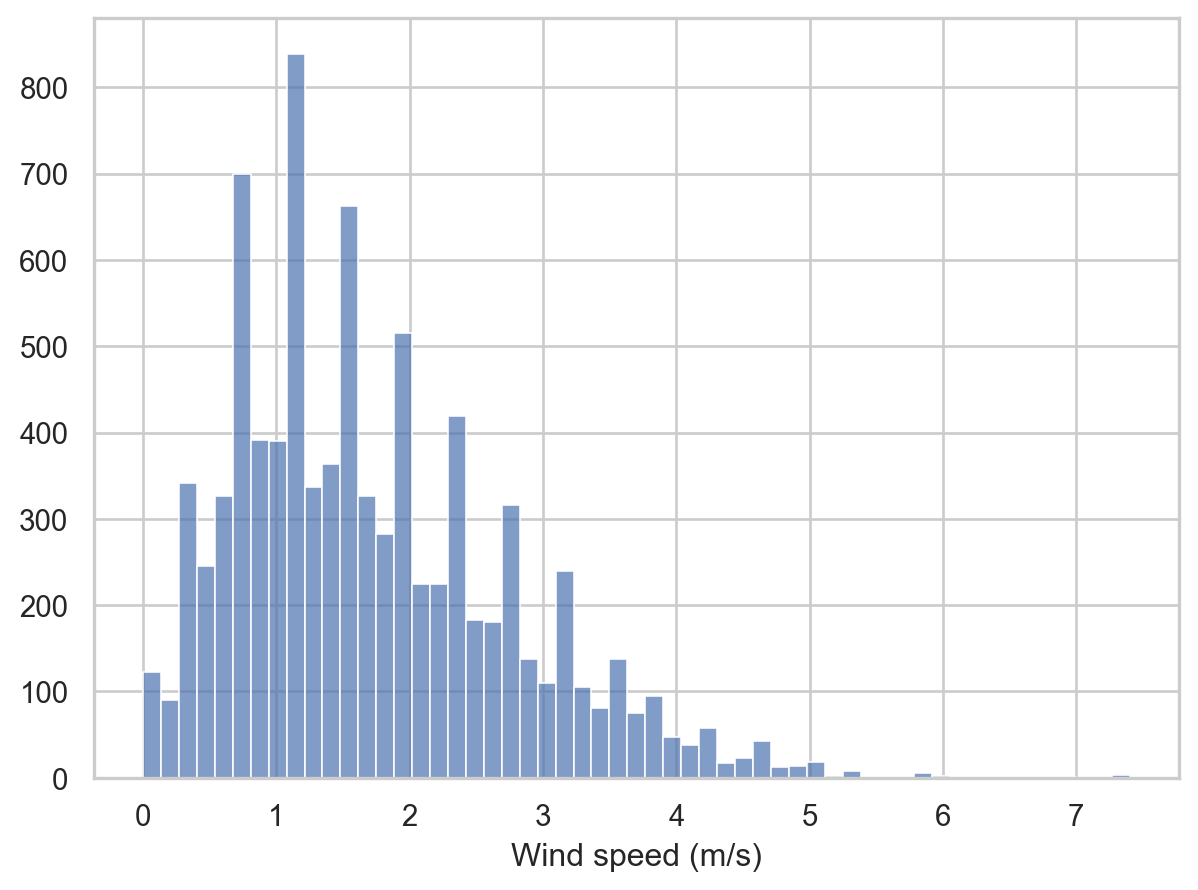

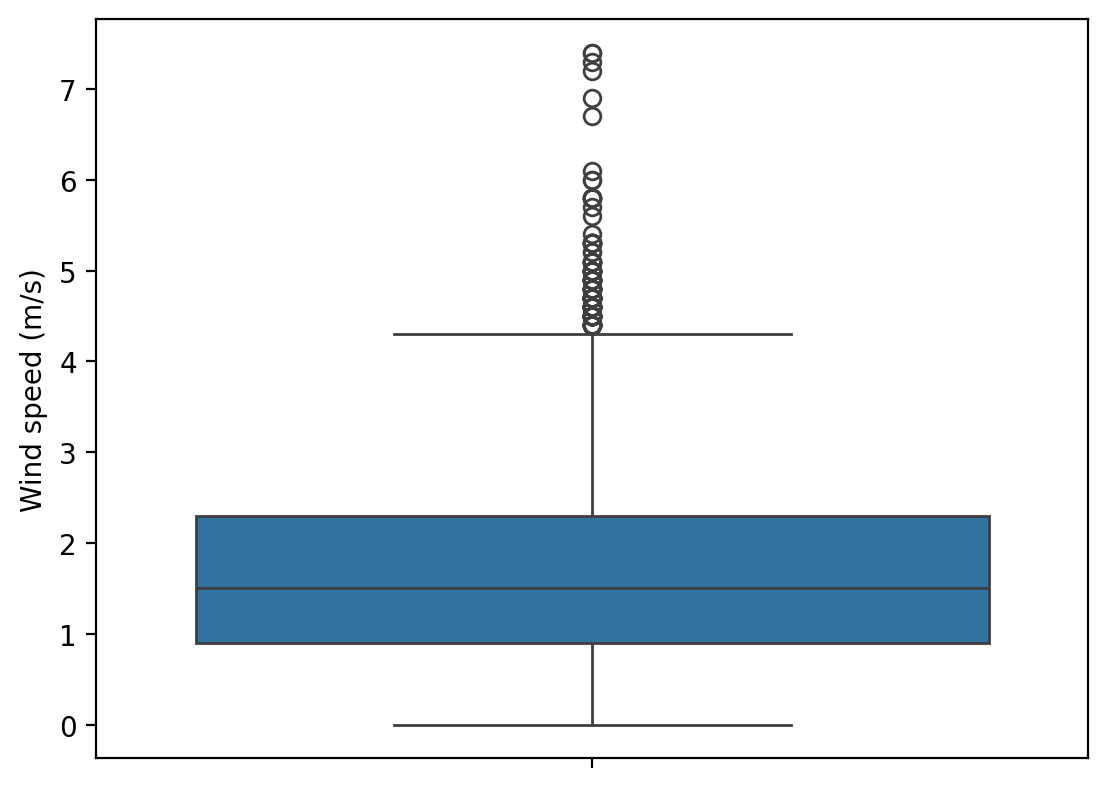

In [210]:
## 풍속에 대한 이상치 확인
print(df3['Wind speed (m/s)'].describe())
print(df3[df3['Wind speed (m/s)']==7.4].value_counts()) ## 풍속이 7.4m/s인 행 확인, 
sns.boxplot(df3['Wind speed (m/s)']) ## 풍속에는 이상치가 있는 것으로 판단
so.Plot(df3, x='Wind speed (m/s)').add(so.Bars(), so.Hist()).theme({**sns.axes_style("whitegrid")})

count    8604.000000
mean        1.663040
std         0.945306
min         0.000000
25%         0.900000
50%         1.500000
75%         2.300000
max         4.300000
Name: Wind speed (m/s), dtype: float64


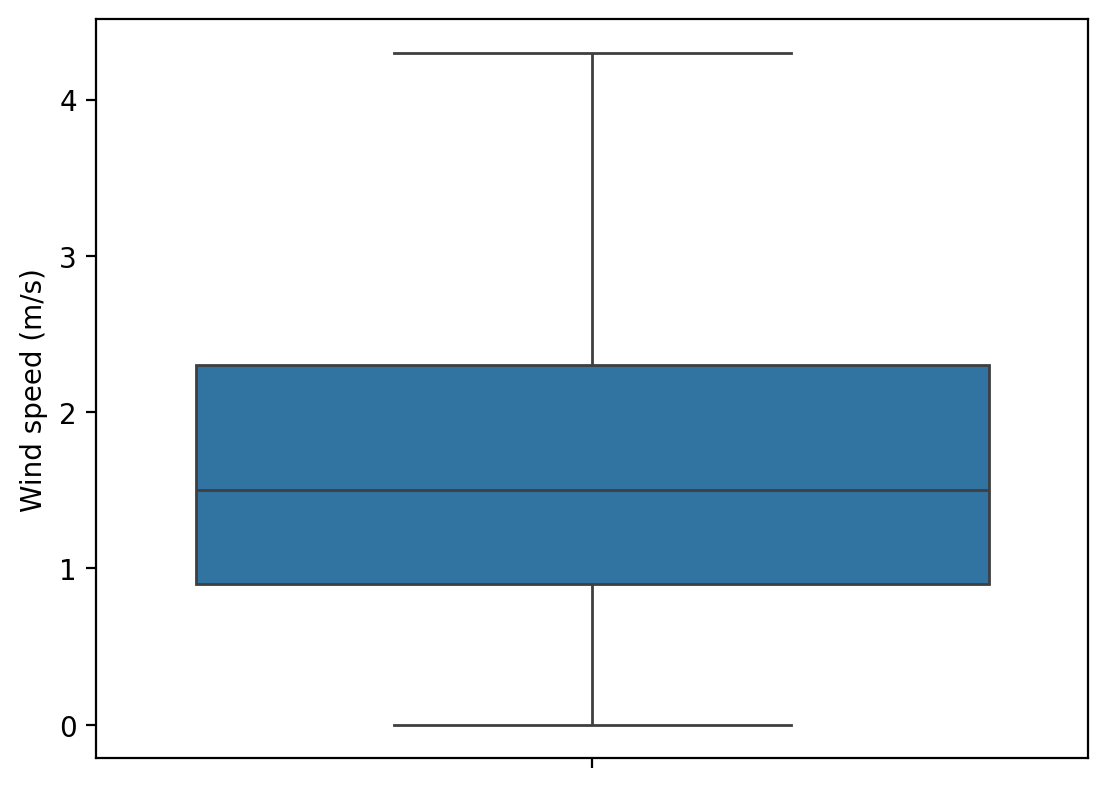

In [213]:
## 기상청에 근거하면 서울의 연평균 풍속은 2.3m/s 이며
## 9월에 1.9정도로 가장 낮고, 4월에 2.7m정도로 가장 높다고 한다.
## 따라서 풍속데이터에는 이상치가 있는것으로 판단.

Q1 = df3['Wind speed (m/s)'].quantile(0.25)
Q3 = df3['Wind speed (m/s)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df3_1 = df3[(df3['Wind speed (m/s)']<upper_bound)&(df3['Wind speed (m/s)']>lower_bound)]
sns.boxplot(df3_1['Wind speed (m/s)']) ## 이상치 제거된 boxplot
print(df3_1['Wind speed (m/s)'].describe())

#### 이상치를 제거한 df3_1 으로 간단한 EDA 진행

Seasons
Summer    2199
Autumn    2162
Spring    2153
Winter    2090
Name: count, dtype: int64

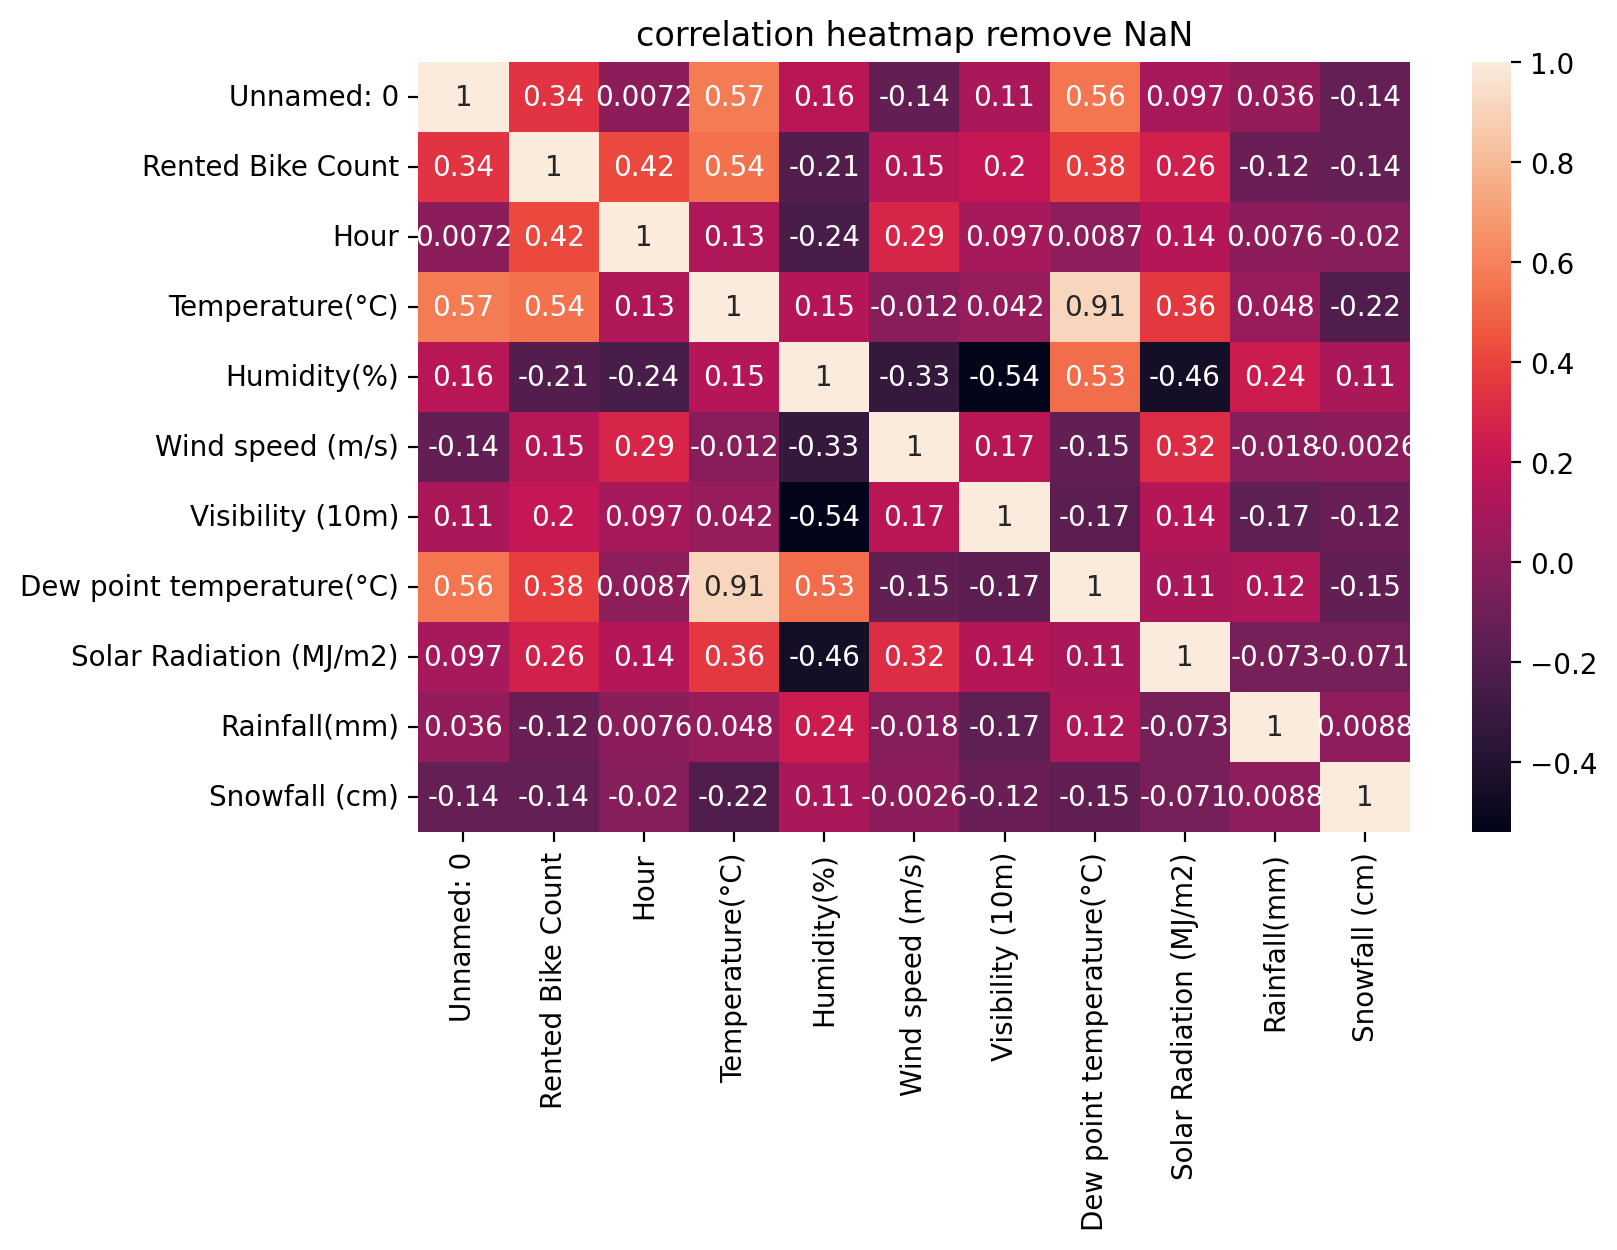

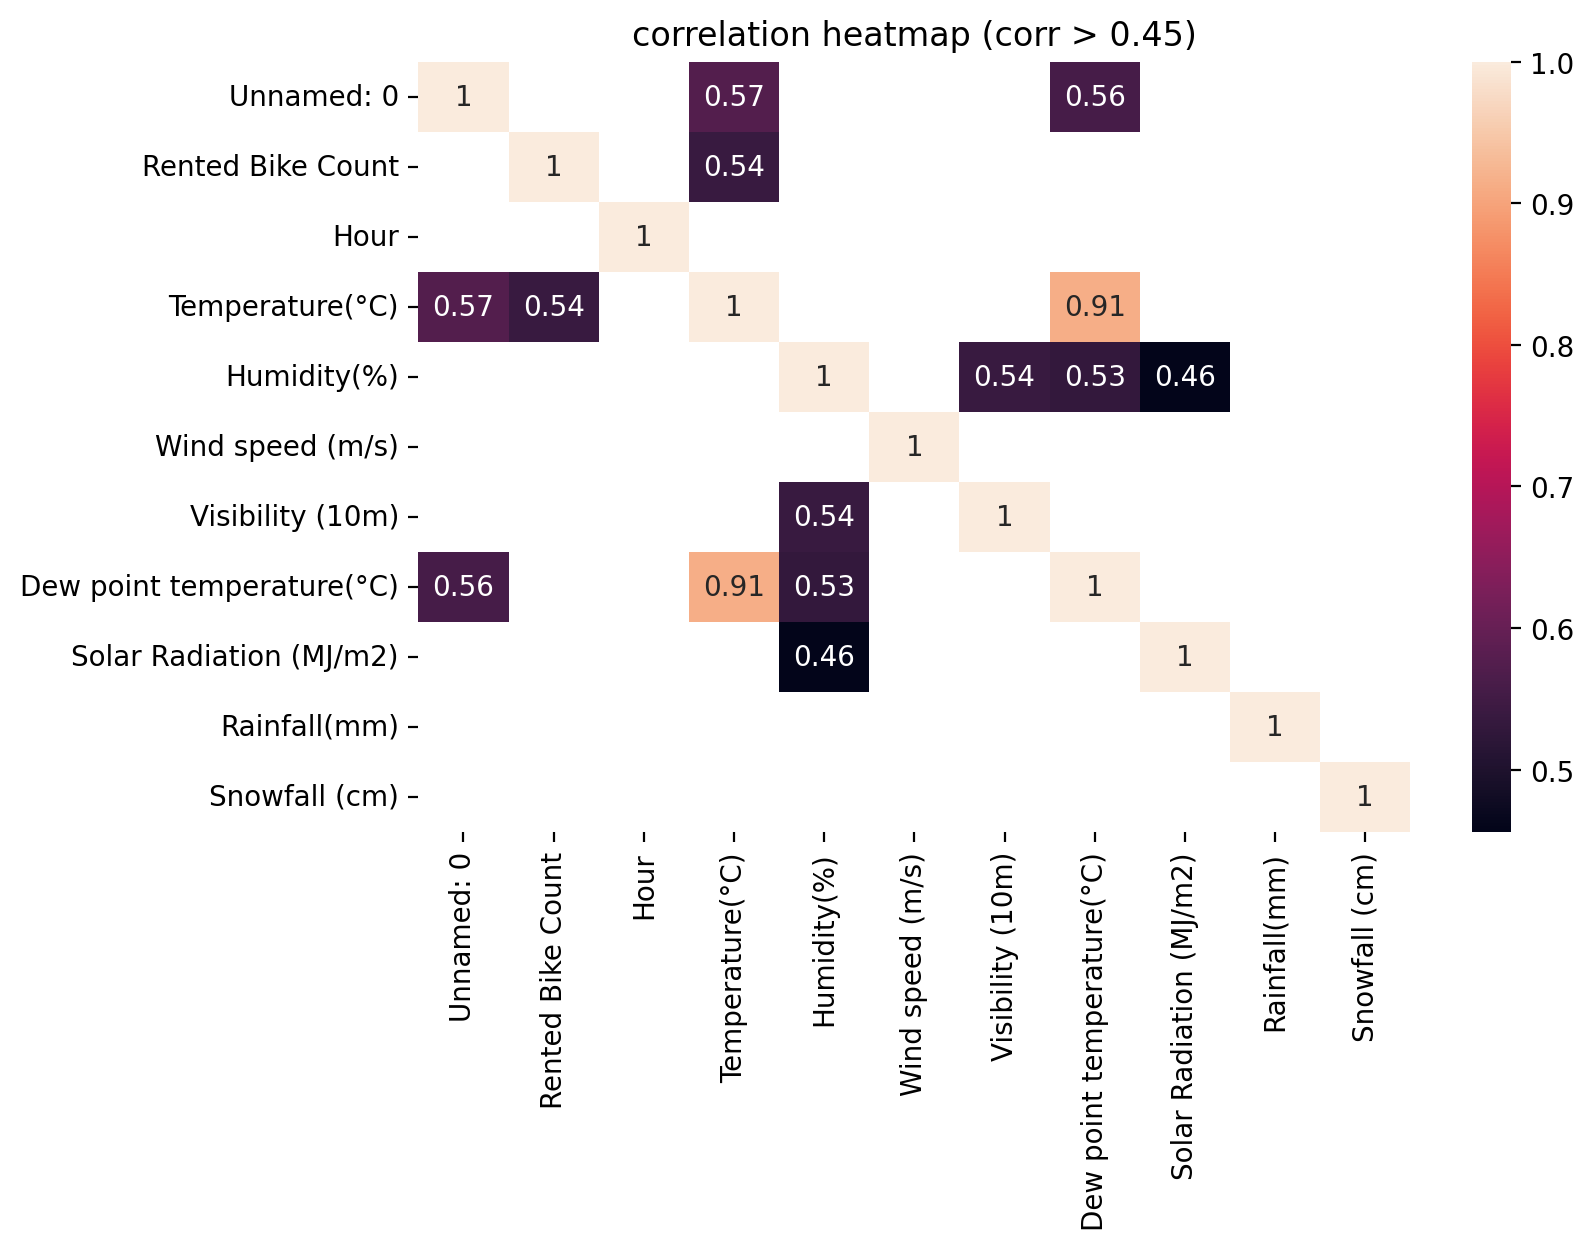

In [214]:
plt.figure(figsize=(8,5))
sns.heatmap(df3_1._get_numeric_data().corr() , annot=True) ## dataframenamd._get_numeric_data()
plt.title('correlation heatmap remove NaN')

corr_mat = df3_1._get_numeric_data().corr().abs()
filtered_corr = corr_mat.where(corr_mat > 0.45)
plt.figure(figsize=(8,5))
sns.heatmap(filtered_corr, annot= True)
plt.title('correlation heatmap (corr > 0.45)')

df3_1.Seasons.value_counts()

Seasons
Summer    2199
Autumn    2162
Spring    2153
Winter    2090
Name: count, dtype: int64

 Seasons
Autumn    1770730
Spring    1568708
Summer    2279911
Winter     470491
Name: Rented Bike Count, dtype: int64

 Seasons
Autumn     819.024052
Spring     728.614956
Summer    1036.794452
Winter     225.115311
Name: Rented Bike Count, dtype: float64


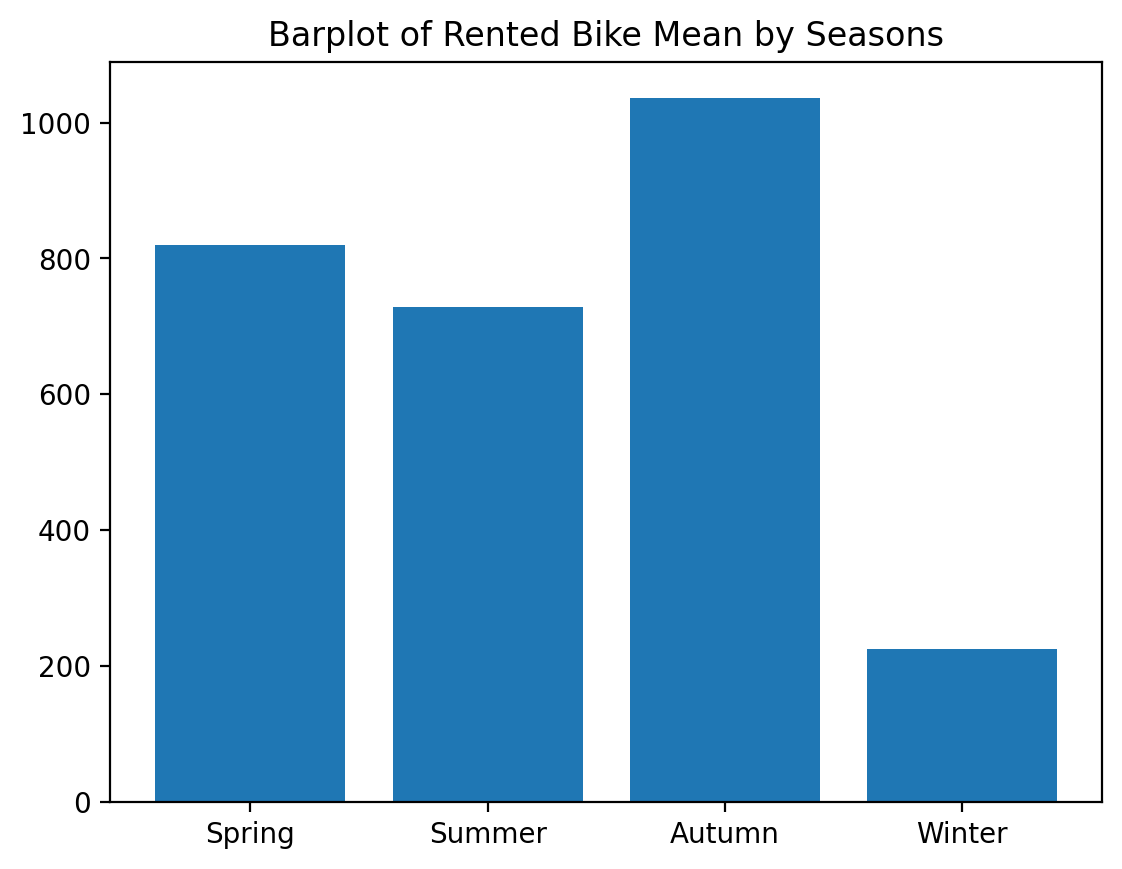

In [247]:
print(df3_1['Seasons'].value_counts())
print('\n',df3_1.groupby('Seasons')['Rented Bike Count'].sum()) ## 계절별 대여량 확인
print('\n',df3_1.groupby(['Seasons'])['Rented Bike Count'].mean())

Seasons_mean = df3_1.groupby('Seasons')['Rented Bike Count'].mean() ## 계절별 대여량 평균 그래프
plt.bar(['Spring', 'Summer', 'Autumn', 'Winter'], Seasons_mean.values) 
plt.title('Barplot of Rented Bike Mean by Seasons')
plt.show()

                           Temperature(°C)  Dew point temperature(°C)
Temperature(°C)                   1.000000                   0.913218
Dew point temperature(°C)         0.913218                   1.000000


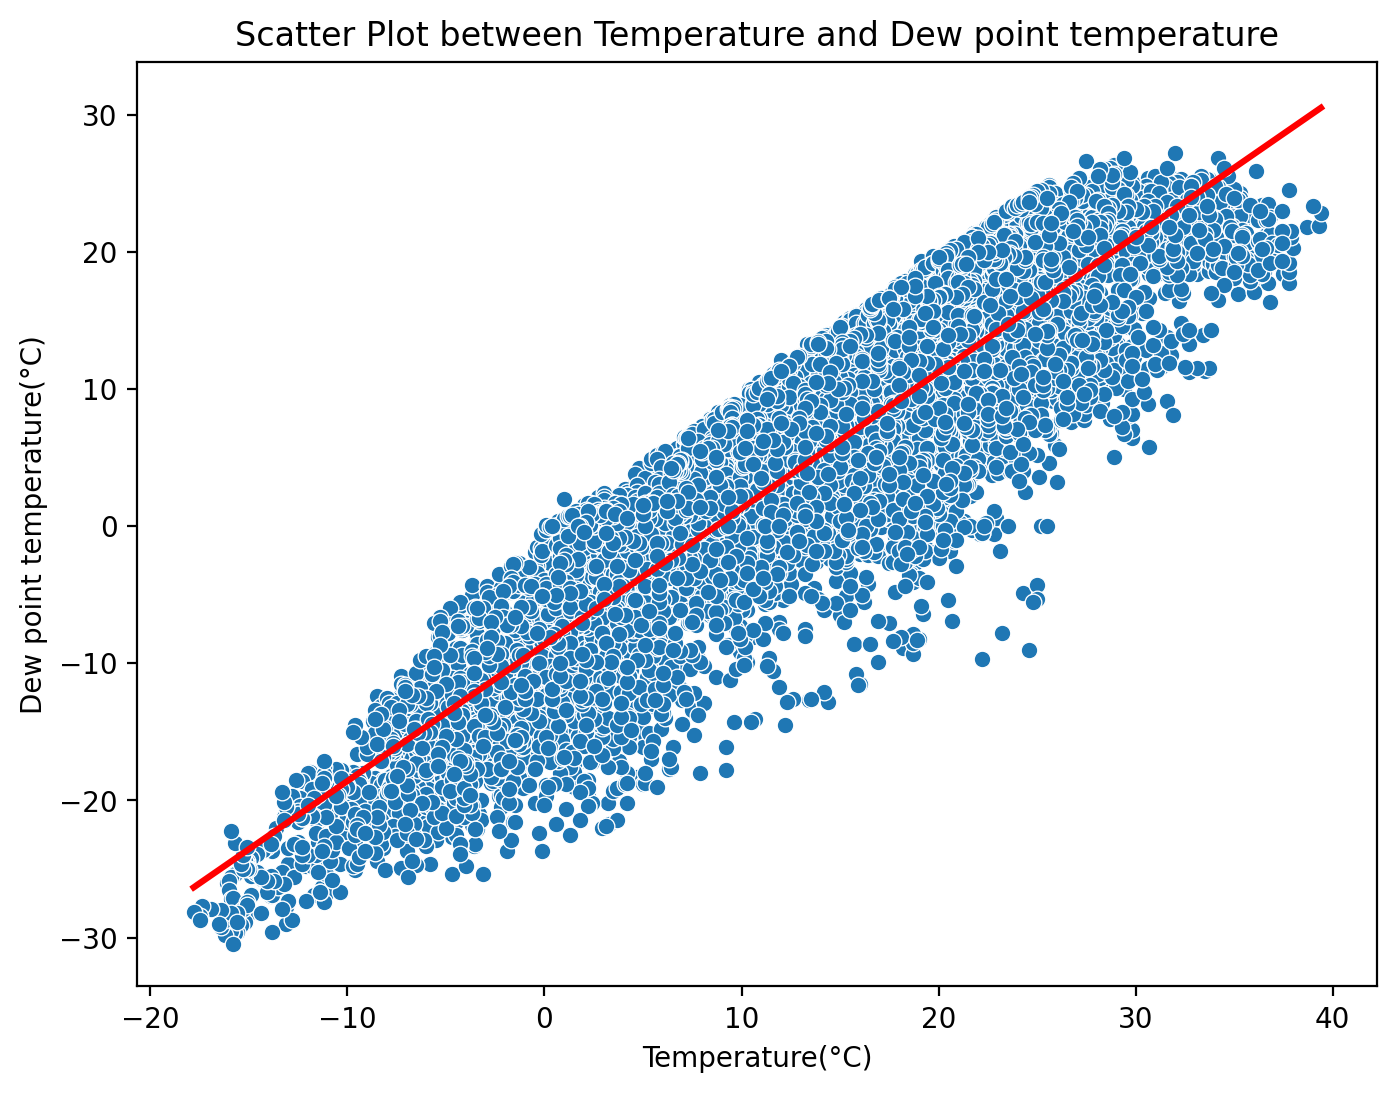

In [230]:
## 온도와 이슬점 사이의 상관관계 확인 >> 원래 이슬점이 온도에 따라 결정되니까,,
print(df3_1[['Temperature(°C)', 'Dew point temperature(°C)']].corr())
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Temperature(°C)', y='Dew point temperature(°C)', data=df3_1)
sns.regplot(x='Temperature(°C)', y='Dew point temperature(°C)', data=df3_1, scatter=False, color='red')
plt.title('Scatter Plot between Temperature and Dew point temperature')
plt.xlabel('Temperature(°C)')
plt.ylabel('Dew point temperature(°C)')
plt.show()


                   Temperature(°C)  Rented Bike Count
Temperature(°C)           1.000000           0.538572
Rented Bike Count         0.538572           1.000000


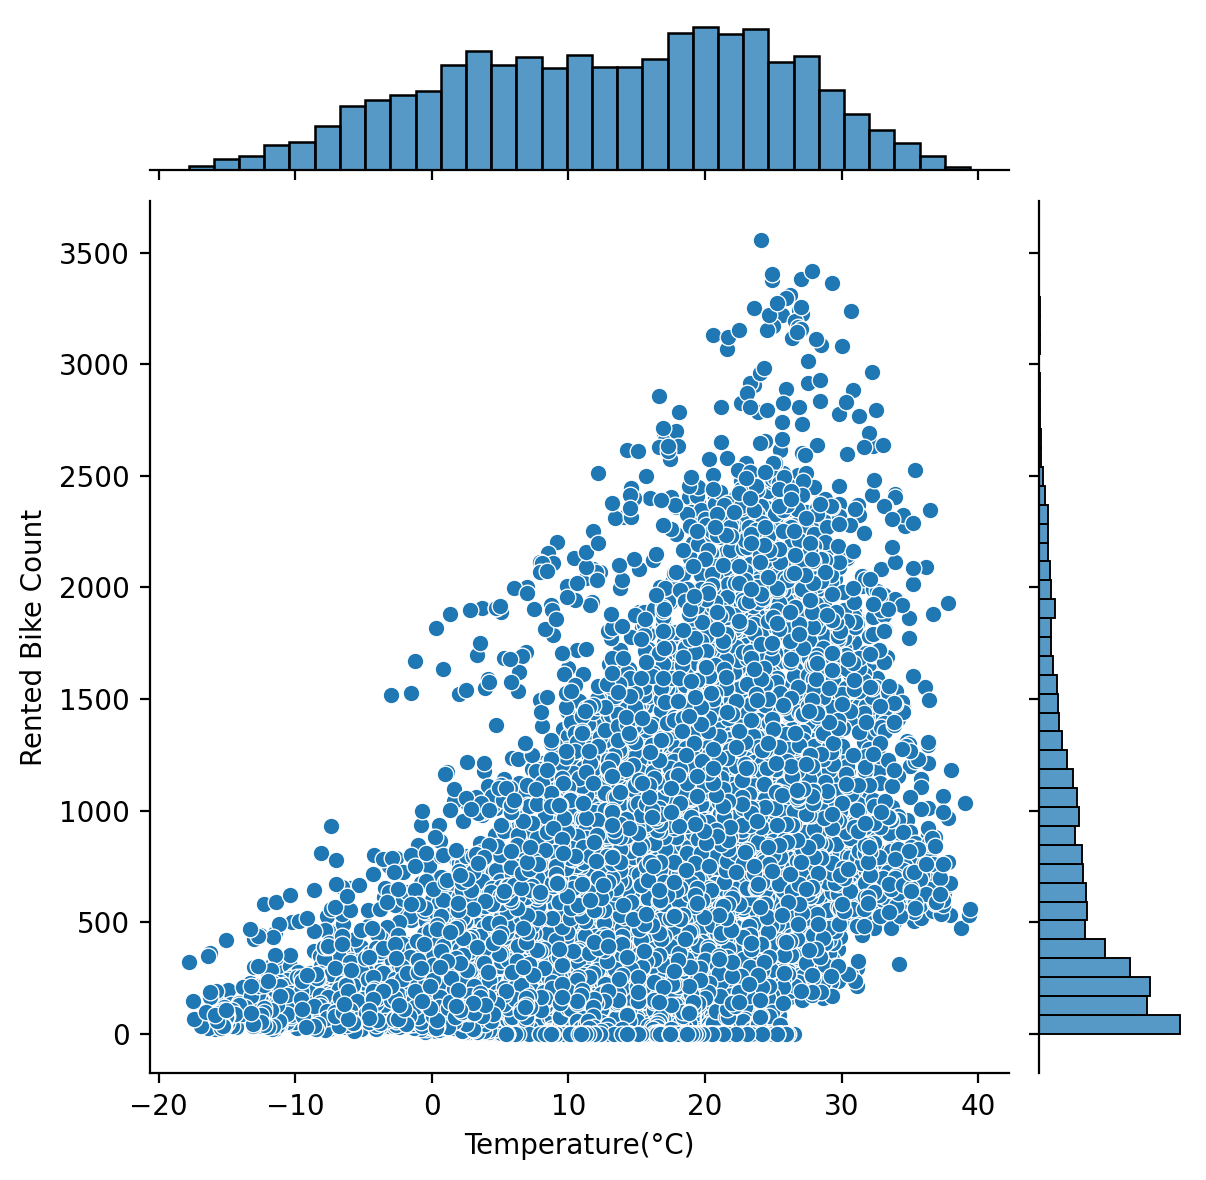

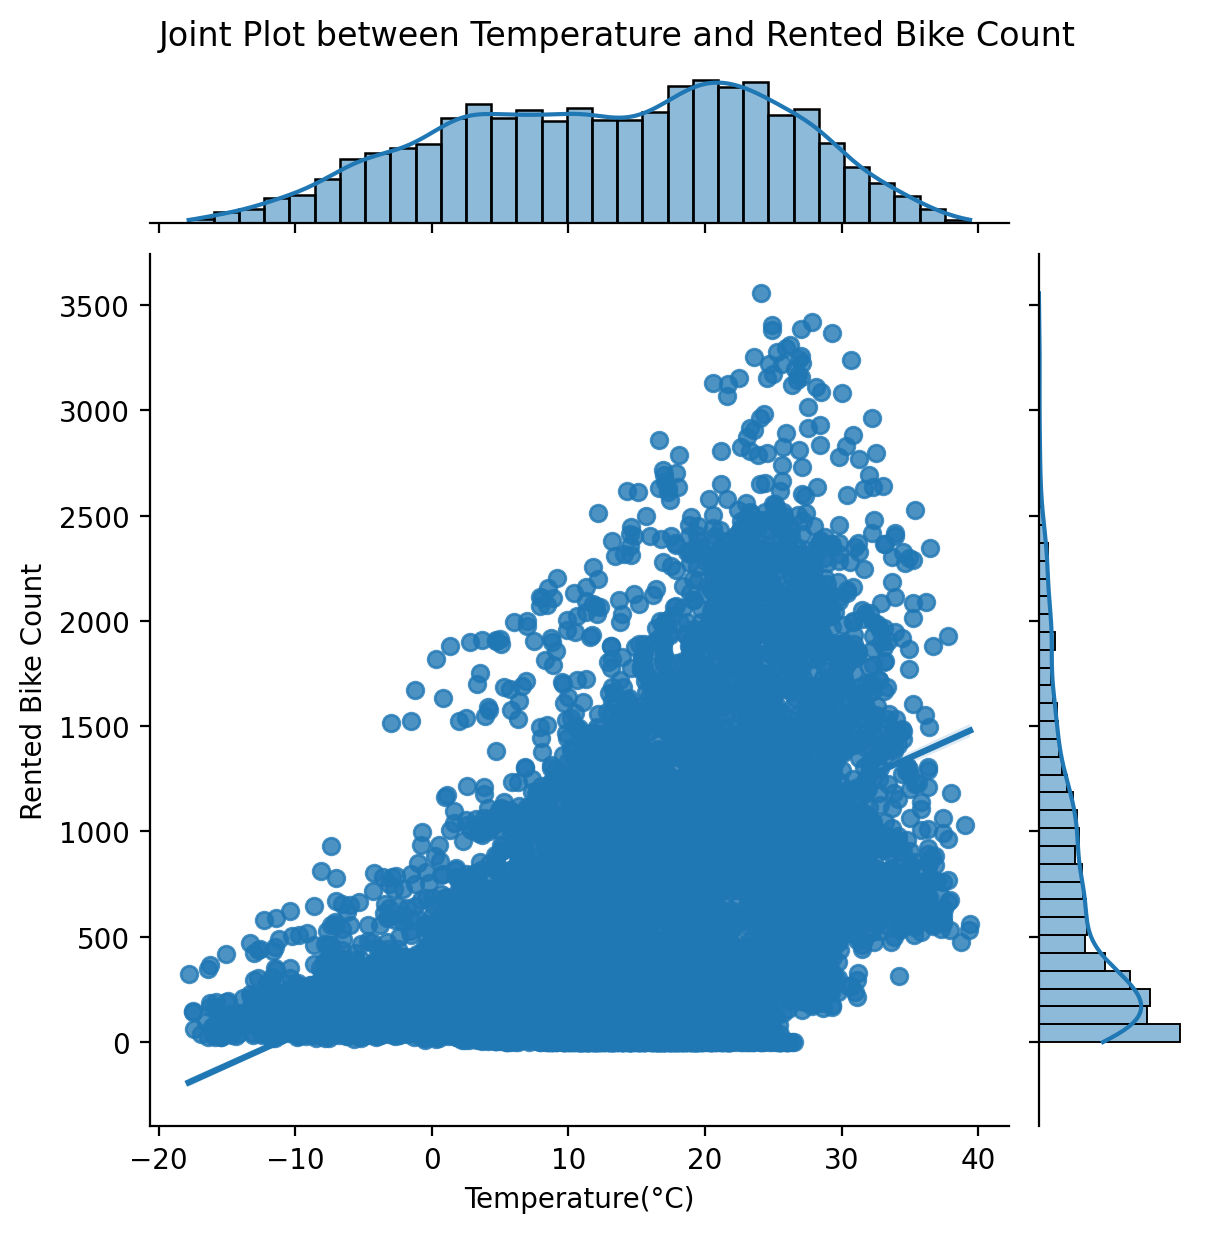

In [239]:
## 온도와 자전거 대여수 사이의 상관관계 비교
print(df3_1[['Temperature(°C)', 'Rented Bike Count']].corr())
plt.figsize = (6,5)
sns.jointplot(x='Temperature(°C)', y='Rented Bike Count', data=df3_1, kind='scatter')
sns.jointplot(x='Temperature(°C)', y='Rented Bike Count', data=df3_1, kind='reg')
plt.suptitle('Joint Plot between Temperature and Rented Bike Count', y=1.02)
plt.show()

                           Rented Bike Count  Dew point temperature(°C)
Rented Bike Count                   1.000000                   0.378804
Dew point temperature(°C)           0.378804                   1.000000


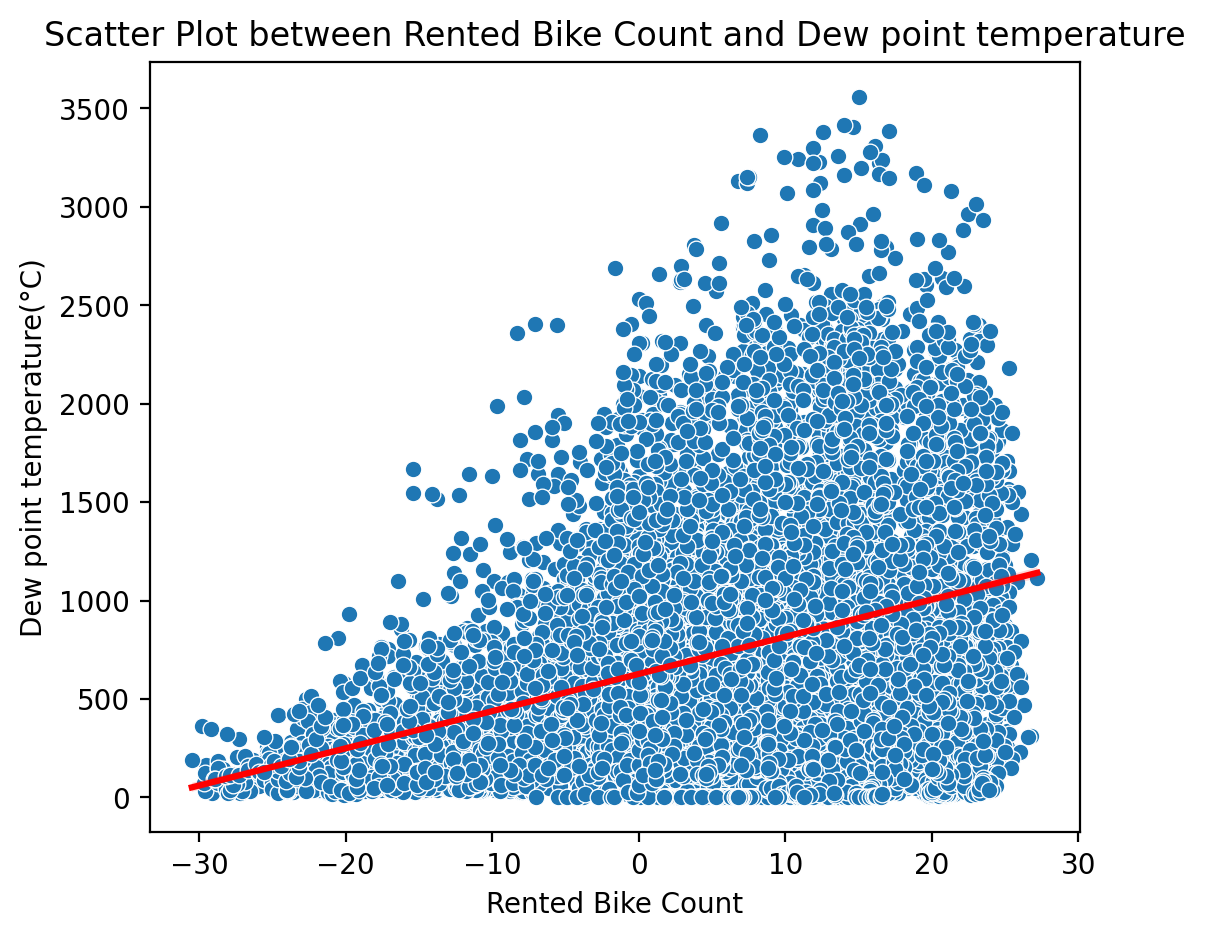

In [242]:
## 온도와 이슬점간의 관계와, 온도와 자전거 대여량 간의 관계에 비해 이슬점과 대여량 사이의 상관관계는 비교적 낮음을 확일 할 수 있음
print(df3_1[['Rented Bike Count', 'Dew point temperature(°C)']].corr())
plt.figure(figsize=(6, 5))
sns.scatterplot(y='Rented Bike Count', x='Dew point temperature(°C)', data=df3_1)
sns.regplot(y='Rented Bike Count', x='Dew point temperature(°C)', data=df3_1, scatter=False, color='red')
plt.title('Scatter Plot between Rented Bike Count and Dew point temperature')
plt.xlabel('Rented Bike Count')
plt.ylabel('Dew point temperature(°C)')
plt.show()

                           Dew point temperature(°C)  Humidity(%)
Dew point temperature(°C)                    1.00000      0.52869
Humidity(%)                                  0.52869      1.00000


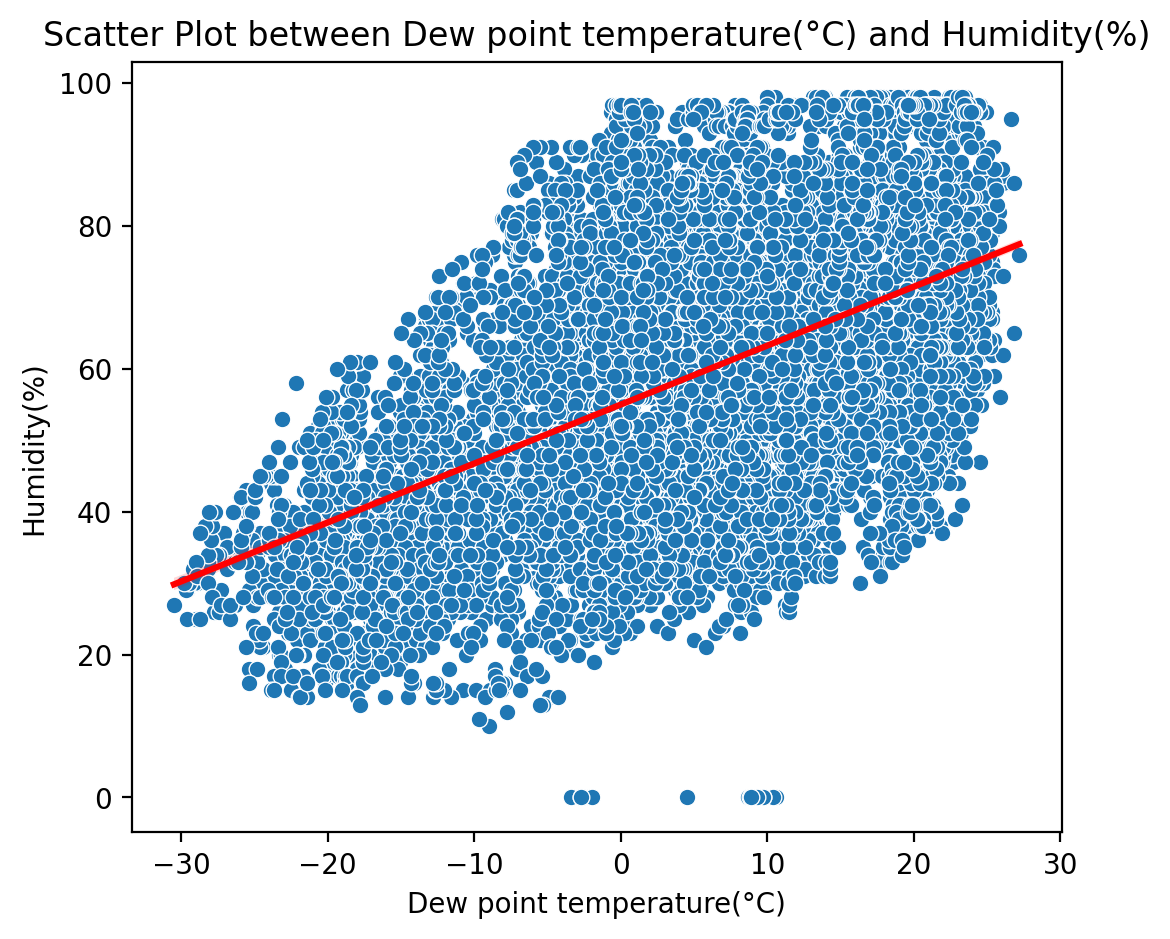

In [244]:
## 이슬점과 상대습도 간의 상관관계 파악
print(df3_1[['Dew point temperature(°C)', 'Humidity(%)']].corr()) 
plt.figure(figsize=(6, 5))
sns.scatterplot(x='Dew point temperature(°C)', y='Humidity(%)', data=df3_1)
sns.regplot(x='Dew point temperature(°C)', y='Humidity(%)', data=df3_1, scatter=False, color='red')
plt.title('Scatter Plot between Dew point temperature(°C) and Humidity(%)')
plt.xlabel('Dew point temperature(°C)')
plt.ylabel('Humidity(%)')
plt.show()


## 습도를 이용하기 위해서는 상대습도와, 공기의 상태를 파악해야하므로 일반적으로 양의 상관관계를 가지지만
## 데이터에 따라 결과가 다르고 자세하게 상관성을 파악해야 함
## 하지만 주어진 데이터는 상대습도를 나타내고 있음!!